In [319]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import torch
from torch import nn
from torch.utils.data import DataLoader
import transformers
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer
from Scripts.utils.bert_utils import load_tokenizer
from nltk.corpus import stopwords 
from Scripts.utils.preprocess_utils import preprocess_texts
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random
import itertools
from Scripts.utils.bert_embeddings import load_bert_embeddings
from Scripts.utils.clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs
from Scripts.utils.general_utils import timer
import Scripts.utils.config as CONFIG
from attm_utils import load_pickle
from attm_metrics import calculate_scores, calculate_scores_single, get_accuracy_from_logits,print_res
from attm_model_utils import evaluate_mt, evaluate_st
from Scripts.utils.bert_utils import load_tokenizer
import  gc
import time
import pickle
import dill
from attm_utils import batch_text_gen, batch_gen_pred, tokenize_4bert_batch
from Scripts.utils.bert_utils import load_model, load_tokenizer, batch_text_gen
from tqdm import tqdm
import h5py
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk import word_tokenize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

To-DO:
* calc top 100 terms con vs lib
* use this new loss 

# CODE

## Data Split

In [3]:
def balance_classes(df):
    """
    """
    min_partisan = df.binary_ps.value_counts().min()
    
    df_0 = df[df.binary_ps == 0].sample(min_partisan,random_state=42)
    df_1 = df[df.binary_ps == 1].sample(min_partisan,random_state=42)
    
    df = pd.concat((df_0,df_1)).sample(frac=1,random_state=42)
    
    return df

def get_label_dist(labels):
    """
    """
    print("1 : %s" %str(sum(labels)))
    print("0 : %s" %str(len(labels) - sum(labels)))

    
def split_data_mixed(c1s,c2,cluster_2_doc_map,df,c2_train_perc=0.10):
    """
    Train - 90 % from c1 mix + 10% from c2
    Test - 50% from c1 mix and 50% from c2
    """
    c1_sizes = [len(cluster_2_doc_map[c]) for c in c1s]
    c2_size = len(cluster_2_doc_map[c2])
    
#     min_c_size = min(c1_sizes+[c2_size])
    
    data_2_split_size = sum(sorted(c1_sizes+[c2_size])[:len(c1s+[c2])-1])
    
#     min_c_size = int(sum(c1_sizes+[c2_size]) * 0.8)
    
    
    train_size = 0.65 * data_2_split_size
    test_size = 0.2 * data_2_split_size
    val_size = 0.15 * data_2_split_size
    
    print("Selected data sizes : ")
    print("Train Size : %s" %str(train_size))
    print("Test Size : %s" %str(test_size))
    print("Val Size : %s" %str(val_size))
    
    c1_mix_train_size = 0.9 * train_size
    c2_train_size = c2_train_perc * train_size
    
    print("Percentage of train size for c in c1mix : %s"%str(c1_mix_train_size/len(c1s)))
    
    
    c1_mix_val_size = 0.9 * val_size
    c2_val_size = 0.1 * val_size
    
    print("Percentage of Val size for c in c1mix : %s"%str(c1_mix_val_size/len(c1s)))
    
    c1_mix_test_size = 0.5 * test_size
    c2_test_size = 0.5 * test_size
    
    print("Percentage of test size for c in c1mix : %s"%str(c1_mix_test_size/len(c1s)))
    
    cmix_train = []
    cmix_test = []
    cmix_val = []
    
    strata_columns = "binary_ps"
    
    # Sample c1mix for train,val,test
    for c in c1s:
        c_df = df.iloc[cluster_2_doc_map[c]]
        c_df["which_cluster"] = [1]*c_df.shape[0]
        c_df["context_pos_words_size"] = c_df["context_pos_words"].apply(lambda x: len(x))
        c_df = c_df[c_df["context_pos_words_size"] > 0]
        c_df = balance_classes(c_df)
        
        c_train, c_test = train_test_split(c_df,test_size=int(c1_mix_test_size/len(c1s)), stratify=c_df[strata_columns], random_state=CONFIG.RANDOM_SEED)
        c_train, c_val = train_test_split(c_train,test_size=int(c1_mix_val_size/len(c1s)), stratify=c_train[strata_columns], random_state=CONFIG.RANDOM_SEED)
        
        if c_train.shape[0] > int(c1_mix_train_size/len(c1s)):
            c_train,_ = train_test_split(c_train,train_size=int(c1_mix_train_size/len(c1s)), stratify=c_train[strata_columns], random_state=CONFIG.RANDOM_SEED)
        
        
        cmix_train.append(c_train)
        cmix_test.append(c_test)
        cmix_val.append(c_val)
        
     # Merge the cluster dfs
    
    cmix_train = pd.concat(cmix_train,axis=0)
    cmix_test = pd.concat(cmix_test,axis=0)
    cmix_val = pd.concat(cmix_val,axis=0)
    
    # Subsample to balance the sizes
    
    if cmix_train.shape[0] > c1_mix_train_size:
        cmix_train,_ = train_test_split(cmix_train,train_size=int(c1_mix_train_size), stratify=cmix_train[strata_columns], random_state=CONFIG.RANDOM_SEED)
    
    if cmix_test.shape[0] > c1_mix_test_size:
        cmix_test,_ = train_test_split(cmix_test,train_size=int(c1_mix_test_size), stratify=cmix_test[strata_columns], random_state=CONFIG.RANDOM_SEED)
    
    if cmix_val.shape[0] > c1_mix_val_size:
        cmix_val,_ = train_test_split(cmix_val,train_size=int(c1_mix_val_size), stratify=cmix_val[strata_columns], random_state=CONFIG.RANDOM_SEED)
        
        
    
    # Sample from c2
    c2_df = df.iloc[cluster_2_doc_map[c2]]
    c2_df["which_cluster"] = [2]*c2_df.shape[0]
    c2_df["binary_ps"] = c2_df["binary_ps"].apply(lambda x: np.abs(x+(-1)))
    c2_df["context_pos_words_size"] = c2_df["context_pos_words"].apply(lambda x: len(x))
    c2_df = c2_df[c2_df["context_pos_words_size"] > 0]
    c2_df = balance_classes(c2_df)
    
    c2_train,c2_test = train_test_split(c2_df,test_size=int(c2_test_size), stratify=c2_df[strata_columns], random_state=CONFIG.RANDOM_SEED)
    c2_train,c2_val = train_test_split(c2_train,test_size=int(c2_val_size), stratify=c2_train[strata_columns], random_state=CONFIG.RANDOM_SEED)
    
    # Subsample to balance the sizes
    
    if c2_train.shape[0] > c2_train_size:
        c2_train,_ = train_test_split(c2_train,train_size=int(c2_train_size), stratify=c2_train[strata_columns], random_state=CONFIG.RANDOM_SEED)
    
    if c2_test.shape[0] > c2_test_size:
        c2_test,_ = train_test_split(c2_test,train_size=int(c2_test_size), stratify=c2_test[strata_columns], random_state=CONFIG.RANDOM_SEED)
    
    if c2_val.shape[0] > c2_val_size:
        c2_val,_ = train_test_split(c2_val,train_size=int(c2_val_size), stratify=c2_val[strata_columns], random_state=CONFIG.RANDOM_SEED)
    
    
    # Combine c1mix with c2
    train = pd.concat([cmix_train,c2_train],axis=0).sample(frac=1,random_state=42)
    test = pd.concat([cmix_test,c2_test],axis=0).sample(frac=1,random_state=42)
    val = pd.concat([cmix_val,c2_val],axis=0).sample(frac=1,random_state=42)
    
    print("\nSampled Data Sizes: ")
    print("Train Size : %s" %str(train.shape))
    get_label_dist(train["binary_ps"])
    print("Test Size : %s" %str(test.shape))
    get_label_dist(test["binary_ps"])
    print("Val Size : %s" %str(val.shape))
    get_label_dist(val["binary_ps"])
    
    return train,test,val
    


## Torch Datasets

In [98]:
class CPDatasetST(torch.utils.data.Dataset):
    """
    Should return bert embedding, label, which cluster, actual text
    Simple case no context word
    """
    def __init__(self, df,hdf_file_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5",glove_vocab_path="",glove=False,max_length = 350):
        self.df = df
        self.glove = glove
        if not self.glove :
            self.hdf_path = hdf_file_path
            self.h5file = h5py.File(self.hdf_path, "r")
            self.d_set = self.h5file.get("bert_embeds")
        
        if self.glove:
            self.glove_path = glove_vocab_path
            self.glove_vocab = load_pickle(self.glove_path)
            self.glove_w2idx = {k: v for v, k in enumerate(self.glove_vocab)}
            self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        t1 = self.df["all_text"].iloc[index]
        y1 = self.df["binary_ps"].iloc[index]
        wc = self.df["which_cluster"].iloc[index]
        
        
        y1 = torch.Tensor([y1])
        wc = torch.Tensor([wc])
        
        x1 = None
        
        if not self.glove:
            x1 = self.d_set[self.df["doc_indices"].iloc[index],:,:]
            x1 = torch.Tensor(x1)
            
        if self.glove:
            x1_indices = [self.glove_w2idx[token] for token in word_tokenize(t1)]
            
            if len(x1_indices) > self.max_length:
                x1_indices = x1_indices[:self.max_length]
            
            if len(x1_indices) < self.max_length:
                to_pad = self.max_length - len(x1_indices)
                x1_indices = x1_indices + [self.glove_w2idx["PAD"]]* to_pad
                
            x1 = torch.LongTensor(x1_indices)
        

        return x1, y1, t1, wc

# For the multitask, each _getitem_ will not return a single item for context words but the list of words, where multiple updates for each sample should occur in train

def get_bert_embeddings(df,model,tokenizer):
    """
    should return a list of dictionaries where dictionary has context word embedding and label
    """
    
    texts_pos = df["context_pos_words"].tolist()
    texts_neg = df["context_neg_words"].tolist()
    single_pos = [pos[0] for pos in texts_pos]
    single_neg = [neg[0] for neg in texts_neg]
    
    embeds_list = []
    
    with torch.no_grad():
        for i in tqdm(range(len(texts_pos)),total=len(texts_pos)):
            
            embed_dict = {}

            encoded_pos = tokenizer.encode_plus(texts_pos[i], add_special_tokens=False, max_length = 1, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
            encoded_neg = tokenizer.encode_plus(texts_neg[i], add_special_tokens=False, max_length = 1, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')

            token_pos = encoded_pos["input_ids"]
            token_neg = encoded_neg["input_ids"]

            token_tensors = torch.cat([token_pos,token_neg],dim=0)
            token_tensors = token_tensors.to(torch.device('cuda:1'))
            batch_out = model(token_tensors)
            batch_hidden_states = batch_out[2]
            batch_12_layer_tensor = batch_hidden_states[-1]

            pos_embed = batch_12_layer_tensor[0,:,:].cpu()
            neg_embed = batch_12_layer_tensor[1,:,:].cpu()
            
            embed_dict["pos"] = pos_embed
            embed_dict["neg"] = neg_embed
            
            embeds_list.append(embed_dict)
    
    return embeds_list
        

class CPDatasetMT(torch.utils.data.Dataset):
    """
    Should return bert embedding, label, which cluster, actual text
    Simple case no context word
    """
    def __init__(self, df,embeds_list,hdf_file_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5",context_word_sample_size=2,glove_vocab_path="",glove=False,max_length = 350):
        self.df = df
        self.glove = glove
        
        if not self.glove :
            self.hdf_path = hdf_file_path
            self.h5file = h5py.File(self.hdf_path, "r")
            self.d_set = self.h5file.get("bert_embeds")
            self.embeds_list = embeds_list
        
        if self.glove:
            self.glove_path = glove_vocab_path
            self.glove_vocab = load_pickle(self.glove_path)
            self.glove_w2idx = {k: v for v, k in enumerate(self.glove_vocab)}
            self.max_length = max_length


    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        t1 = self.df["all_text"].iloc[index]
        y1 = self.df["binary_ps"].iloc[index]
        wc = self.df["which_cluster"].iloc[index]
        
        
        y1 = torch.Tensor([y1])
        wc = torch.Tensor([wc])
        
        x1 = None
        x2 = None
        
        if not self.glove:
            x1 = self.d_set[self.df["doc_indices"].iloc[index],:,:]
            # create a dictionary of tensors here, with labels
            #{pos_embeds, pos_labels, neg_embeds, neg_labels}
            x2 = torch.cat([self.embeds_list[index]["pos"],self.embeds_list[index]["neg"]],dim=0)
            x1 = torch.Tensor(x1)
        
        if self.glove:
            context_pos_words = self.df["context_pos_words"].iloc[index]
            context_neg_words = self.df["context_neg_words"].iloc[index]
            
            pos_glove_idx = torch.Tensor([self.glove_w2idx[context_pos_words[0]]])
            neg_glove_idx = torch.Tensor([self.glove_w2idx[context_neg_words[0]]])
            
            x2 = torch.cat([pos_glove_idx,neg_glove_idx],dim=0)
            x2 = x2.type(torch.LongTensor)
            
            x1_indices = [self.glove_w2idx[token] for token in word_tokenize(t1)]
            
            if len(x1_indices) > self.max_length:
                x1_indices = x1_indices[:self.max_length]
            
            if len(x1_indices) < self.max_length:
                to_pad = self.max_length - len(x1_indices)
                x1_indices = x1_indices + [self.glove_w2idx["PAD"]]* to_pad
                
            x1 = torch.LongTensor(x1_indices)
            
        return x1, x2, y1, t1, wc

## Torch Models

In [306]:
def create_emb_layer(weights_matrix, non_trainable=False):
    """
    """
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim


class AttentionST(nn.Module):
    
    def __init__(self,embedding_size=768,verbose=True,which_forward=2,with_attention=True,dropout=0.3,glove=False,weights_matrix=None):
        super(AttentionST,self).__init__()
        
        self.with_attention = with_attention
        self.embedding_size = embedding_size
        
        self.glove = glove
        
        if self.glove:
        
            self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, False)
        
        if self.glove:
            self.embedding_size=300
        
        self.attention = nn.Linear(in_features=self.embedding_size,
                                       out_features=1,
                                       bias=False)
        
        
        self.dropout = nn.Dropout(dropout)
        
        self.recom_pred = nn.Linear(in_features=self.embedding_size,
                                    out_features=1,
                                    bias=True)

        
        # Softmax Activation
        self.softmax = nn.Softmax(dim=-1)
        
        # Sigmoid Activation
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self,embeddings):
        """
        """
        
        batch_size = embeddings.size(0)
        
        if self.with_attention:
        # iterate over articles in a given batch
            attention_vector_batch = []

            for sent in range(batch_size):
                
                sent_embed_matrix = None
                
                if not self.glove:

                    sent_embed_matrix = embeddings[sent,:,:] # 500 x 768
                
                if self.glove:
                    sent_embed_matrix = self.embedding(embeddings[sent,:])

                word_weights = self.dropout(self.attention(sent_embed_matrix)).squeeze()

                self.normalized_word_weights = self.softmax(word_weights) # input is 500 x 1, output is 500 x 1

                attention_vector = sent_embed_matrix.T .mul(self.normalized_word_weights).sum(dim=1)

                attention_vector_batch.append(attention_vector.unsqueeze(-1).T) 
                

            attention_vector_batch = torch.cat(attention_vector_batch,dim=0) # we get (batch_size,768)
            
            y_preds = self.sigmoid(self.recom_pred(attention_vector_batch)).squeeze()
        
            return y_preds
        
        else:
            
            y_pred = None
            
            if self.glove:
                glove_embeds = torch.stack([torch.mean(self.embedding(embedding),dim=0) for embedding in embeddings])
                y_pred = self.sigmoid(self.recom_pred(glove_embeds)).squeeze()
            
            if not self.glove:
                y_pred = self.sigmoid(self.recom_pred(embeddings[:,0,:])).squeeze()
            
            return y_pred


        

class AttentionMT(nn.Module):
    
    def __init__(self,embedding_size=768,dropout=0.1,glove=False,weights_matrix=None,bad_embeds=None,use_loss2=False):
        super(AttentionMT,self).__init__()
        
        self.glove = glove
        self.embedding_size=embedding_size
        
        if self.glove:
            self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, False)
            
            self.embedding_size = 300
        
        self.attention = nn.Linear(in_features=self.embedding_size,
                                   out_features=1,
                                   bias=False)
        
        self.interm_word = nn.Linear(in_features=self.embedding_size,
                                    out_features=self.embedding_size,
                                    bias=True)
        
        self.dropout = nn.Dropout(dropout)
        
        self.word_weights = nn.Linear(in_features=self.embedding_size,
                                   out_features=1,
                                   bias=True)
        
        # Recommendation Network
        # ------------------------
        
        self.recom_pred = nn.Linear(in_features=self.embedding_size,
                                    out_features=1,
                                    bias=True)
        
        # Softmax Activation
        self.softmax = nn.Softmax(dim=-1)
        
        # Sigmoid Activation
        self.sigmoid = nn.Sigmoid()
        
        self.att_con_vec = None
        
        self.bad_embeds = bad_embeds
        
        self.use_loss2 = use_loss2
    
    def forward(self,text_embeds,context_embed):
        """
        """        
        attention_vector_batch = []
        
        batch_size = text_embeds.size(0)
        
        for sent in range(batch_size):
            
            sent_embed_matrix = None

            if not self.glove:

                sent_embed_matrix = text_embeds[sent,:,:] # 500 x 768

            if self.glove:
                sent_embed_matrix = self.embedding(text_embeds[sent,:])

#             sent_embed_matrix = text_embeds[sent,:,:] # 500 x 768

            word_weights = self.dropout(self.attention(sent_embed_matrix)).squeeze()

            self.normalized_word_weights = self.softmax(word_weights) # input is 500 x 1, output is 500 x 1

            attention_vector = sent_embed_matrix.T.mul(self.normalized_word_weights).sum(dim=1)

            attention_vector_batch.append(attention_vector.unsqueeze(-1).T) 
                
                
        self.att_con_vec  = torch.cat(attention_vector_batch,dim=0) # we get (batch_size,768)

        y_preds = self.sigmoid(self.recom_pred(self.att_con_vec))
        
        w_loss = None
        
        if self.use_loss2:
            
            w_loss = torch.vstack([self.sigmoid(torch.mul(self.att_con_vec, bde).sum(axis=1).mean()) for bde in self.bad_embeds]).mean()
        
        
        word_preds = None
        
        if context_embed is not None:
        # Word Prediction Part
        
            # convert 3d to 2d matrix
            if self.glove:
                context_embed = self.embedding(context_embed)
            
            if not self.glove:
                original_size = context_embed.size()
                context_embed = context_embed.view(original_size[0],original_size[-1])

            dot_prod_sim = torch.mul(self.att_con_vec, context_embed) # dot product between (N,768) and (N,768)

            word_preds = self.sigmoid(self.word_weights(dot_prod_sim))

            word_preds = word_preds.view(word_preds.size()[0],1)
        
        return y_preds,word_preds,self.att_con_vec,w_loss

## Torch Model Trainers

In [249]:
def count_words(X):
    XX = X.copy()
    XX.data /= XX.data
    return XX.sum(axis=0).A1 / X.shape[0]

def get_bad_terms(X, labels, vocab):
    """
    bad terms correlate with class label across all documents
    and are relatively frequent.
    We fit a simple logistic regression on all documents, 
    find top 100 terms per class, then select 100 most frequent from those.
    """
    clf = LogisticRegression(C=1, random_state=42, max_iter=1000)
    clf.fit(X, labels)
    c = clf.coef_[0]
    bad_terms = []
    feats = np.array(vocab.get_feature_names())
    for i in np.argsort(c)[::-1][:200]:
        bad_terms.append(feats[i])
    for i in np.argsort(c)[:200]:
        bad_terms.append(feats[i])
    bad_terms = set(bad_terms)    
    word_count = count_words(X)
    f = sorted([(word_count[vocab.vocabulary_[w]], w)  for w in bad_terms])[::-1][:200]
    return set(i[1] for i in f)

def match_bad_terms(tokens_train, tokens_test, bad_terms):    
    all_toks = set()
    for t in tokens_train:
        all_toks.update(t)
    for t in tokens_test:
        all_toks.update(t)
    return sorted(list(bad_terms & all_toks))

def get_bad_term_embeddings(bad_terms):
    """
    """
    tokenizer = load_tokenizer()
    model= load_model()
    model.to(torch.device('cuda:0'))
    bad_term_embeds = []
    bad_term_tokens = []
    for b in bad_terms:
        bert_tok = tokenizer.encode_plus(b, add_special_tokens=False, max_length = 1, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
        
        token_id = bert_tok["input_ids"]
        token = tokenizer.convert_ids_to_tokens(token_id)
        bad_term_tokens.append(token)
        token_tensors = token_id.to(torch.device('cuda:0'))
        batch_out = model(token_tensors)
        batch_hidden_states = batch_out[2]
        batch_12_layer_tensor = batch_hidden_states[-1]
        token_embed = batch_12_layer_tensor.cpu()
        bad_term_embeds.append(token_embed)
    
    return bad_term_embeds,bad_term_tokens

In [358]:
def seed_all(seed):
    if not seed:
        seed = 10

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# loss2 = self.sigmoid(torch.mul(self.e, bad_embeddings).sum(axis=1).mean())

@timer
def run_ssda_ST(train,test,val,lr,epochs=2,batch_size=8,dropout=0.1,cuda_device=torch.device('cuda:1'),num_workers=1,with_attention=True,cp=None,avg_type="binary",glove=False,extreme=False):
    """
    """
    seed_all(42)
    
    weights_matrix = None
    
    if glove:
        if not extreme:
            weights_matrix = load_pickle("Data_4_AttM/glove_mat.pkl")
            weights_matrix = torch.from_numpy(weights_matrix)
        
        if extreme:
            weights_matrix = load_pickle("Data_4_AttM/glove_mat_extreme.pkl")
            weights_matrix = torch.from_numpy(weights_matrix)
    
    model = AttentionST(embedding_size=768,with_attention=with_attention,dropout = dropout,glove=glove,weights_matrix=weights_matrix)
    model.to(cuda_device)
    loss_func = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    
    epoch_losses = {}
    total_losses = []
    total_losses_val = []
    word_losses = []
    rs_losses = []
    
    glove_vocab_path = ""
    
    if glove:
        if extreme:
            glove_vocab_path = "Data_4_AttM/vocab_target_glove_extreme.pkl"
        
        if not extreme:
            glove_vocab_path = "Data_4_AttM/vocab_target_glove.pkl"
            
    bert_hdf_file_path = None
    
    if extreme:
        bert_hdf_file_path = "/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm_extreme.hdf5"
    
    if not extreme:
        bert_hdf_file_path = "/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5"
    
    train_dataset = CPDatasetST(train,hdf_file_path=bert_hdf_file_path,glove_vocab_path=glove_vocab_path,glove=glove)
    test_dataset = CPDatasetST(test,hdf_file_path=bert_hdf_file_path,glove_vocab_path=glove_vocab_path,glove=glove)
    val_dataset = CPDatasetST(val,hdf_file_path=bert_hdf_file_path,glove_vocab_path=glove_vocab_path,glove=glove)
    
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True,worker_init_fn=seed_worker)
    test_dataloader = DataLoader(test_dataset,batch_size=100,num_workers=num_workers,shuffle=True,worker_init_fn=seed_worker)
    val_dataloader = DataLoader(val_dataset,batch_size=100,num_workers=num_workers,shuffle=True,worker_init_fn=seed_worker)
    
    for epoch in tqdm(range(epochs),total=epochs):
        batch_losses =  []
        # Training
        for batch_num, (x1,y1,t1,wc) in enumerate(train_dataloader):
            
            model.train()

            x1,y1 = x1.to(cuda_device),y1.to(cuda_device)
            
            opt.zero_grad() # reset all the gradient information
    
            y_pred = model(x1)
            
            if batch_size == 1:
                y1 = y1.view(1)
            
            if batch_size > 1:
                y1 = y1.squeeze()
            
            total_loss = loss_func(y_pred,y1.squeeze()) 
            
            total_loss.backward()
            
            opt.step()
            
            batch_losses.append(total_loss.item())
        
        # Validation
        batch_losses_val =  []
        for bn_v, (xv1,yv1,tv1,wcv) in enumerate(val_dataloader):
            
            model.eval()
            with torch.no_grad():
                xv1,yv1 = xv1.to(cuda_device),yv1.to(cuda_device)

                y_pred = model(xv1)
                
                if batch_size == 1:
                    yv1 = yv1.view(1)
            
                if batch_size > 1:
                    yv1 = yv1.squeeze()

                total_loss_val = loss_func(y_pred,yv1) 
                batch_losses_val.append(total_loss_val.item())
        
        avg_batch_loss = np.mean(batch_losses)
        avg_batch_loss_val = np.mean(batch_losses_val)
        total_losses.append(avg_batch_loss)
        total_losses_val.append(avg_batch_loss_val)

        
    epoch_losses["total_loss"] = total_losses
    epoch_losses["total_loss_val"] = total_losses_val
        
    scores_train = evaluate_st(model,train_dataloader,device=cuda_device,avg_type=avg_type)
    scores_val = evaluate_st(model,val_dataloader,device=cuda_device,avg_type=avg_type)
    scores_test = evaluate_st(model,test_dataloader,device=cuda_device,avg_type=avg_type)
    
    x1 = None
    y1 = None
    total_loss = None
    opt = None
    

    del x1
    del y1

    gc.collect()
    torch.cuda.empty_cache()
    
    return model, epoch_losses, scores_train, scores_test, scores_val


@timer
def run_ssda_MT(train,test,val,cw_embed_train,cw_embed_test,cw_embed_val,lr,word_loss_w,epochs=2,batch_size=8,dropout=0.1,cuda_device=torch.device('cuda:1'),num_workers=1,l2=0.05,avg_type="binary",glove=False,extreme=False,loss2=False,bad_term_embeds=None):
    """
    """
    seed_all(42)
    
    weights_matrix = None
    
    if glove:
        if not extreme:
            weights_matrix = load_pickle("Data_4_AttM/glove_mat.pkl")
            weights_matrix = torch.from_numpy(weights_matrix)
        
        if extreme:
            weights_matrix = load_pickle("Data_4_AttM/glove_mat_extreme.pkl")
            weights_matrix = torch.from_numpy(weights_matrix)
    
    if loss2 and bad_term_embeds != None:
        bad_term_embeds = bad_term_embeds.to(cuda_device)
 
    
    model = AttentionMT(embedding_size=768,dropout=dropout,glove=glove,weights_matrix=weights_matrix,bad_embeds = bad_term_embeds,use_loss2=loss2)
    model.to(cuda_device)
    loss_func = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    
    epoch_losses = {}
    total_losses = []
    word_losses = []
    rs_losses = []
    total_losses_val = []
    word_losses_val = []
    rs_losses_val = []
    
    glove_vocab_path = ""
    
    if glove:
        if extreme:
            glove_vocab_path = "Data_4_AttM/vocab_target_glove_extreme.pkl"
        
        if not extreme:
            glove_vocab_path = "Data_4_AttM/vocab_target_glove.pkl"
            
    bert_hdf_file_path = None
    
    if extreme:
        bert_hdf_file_path = "/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm_extreme.hdf5"
    
    if not extreme:
        bert_hdf_file_path = "/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5"
    
    train_dataset = CPDatasetMT(train,cw_embed_train,hdf_file_path=bert_hdf_file_path,glove_vocab_path=glove_vocab_path,glove=glove)
    test_dataset = CPDatasetMT(test,cw_embed_test,hdf_file_path=bert_hdf_file_path,glove_vocab_path=glove_vocab_path,glove=glove)
    val_dataset = CPDatasetMT(val,cw_embed_val,hdf_file_path=bert_hdf_file_path,glove_vocab_path=glove_vocab_path,glove=glove)
    
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers, shuffle=True,worker_init_fn=seed_worker)
    test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True,worker_init_fn=seed_worker)
    val_dataloader = DataLoader(val_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True,worker_init_fn=seed_worker)
        
    for epoch in tqdm(range(epochs),total=epochs):
        
        batch_losses_total = []
        batch_losses_rec = []
        batch_losses_word = []
        
        for batch_num, (x1, x2, y1, t1, wc) in enumerate(train_dataloader):
            
            text_x = x1
            if not loss2:
                for label_cw in range(2):
                    # expand the context words 
                    context_word_embed = None
                    if glove:
                        context_word_embed = x2[:,label_cw]
                    if not glove:
                        context_word_embed = x2[:,label_cw,:]
                    if label_cw == 0:
                        word_labels = torch.Tensor([1]*x2.size()[0])
                    if label_cw == 1:
                        word_labels = torch.Tensor([0]*x2.size()[0])
                    model.train()
                    text_x,context_word_embed,y1,word_labels = text_x.to(cuda_device),context_word_embed.to(cuda_device),y1.to(cuda_device),word_labels.to(cuda_device)
                    opt.zero_grad() # reset all the gradient information
                    y_pred, context_pred,attcvec,_ = model(text_x, context_word_embed)
                    rec_loss = loss_func(y_pred,y1)
                    word_loss = loss_func(context_pred.squeeze(),word_labels)
                    total_loss = (1 - word_loss_w)*rec_loss + (word_loss_w * word_loss) + model.word_weights.weight.norm(p=2) * l2
                    total_loss.backward()
                    opt.step()
                    
                batch_losses_rec.append(rec_loss.item())
                batch_losses_word.append(word_loss.item())
                batch_losses_total.append(total_loss.item())
                
#             if loss2:
#                 model.train()
#                 text_x,y1 = text_x.to(cuda_device),y1.to(cuda_device)
#                 opt.zero_grad() 
#                 y_pred, context_pred,attcvec,w_loss = model(text_x, None)
#                 word_loss = w_loss.item()
# #                 print(word_loss)
# #                 print(y1.requires_grad)
# #                 print(y_pred.requires_grad)
# #                 print(w_loss.requires_grad)
#                 rec_loss = loss_func(y_pred,y1)
# #                 print(rec_loss.requires_grad)
#                 total_loss = (1 - word_loss_w)*rec_loss + (word_loss_w * word_loss) 
#                 total_loss.backward()
#                 opt.step()
#                 batch_losses_rec.append(rec_loss.item())
#                 batch_losses_word.append(word_loss)
#                 batch_losses_total.append(total_loss.item())
            
            
        avg_batch_losses_total = np.mean(batch_losses_total)
        avg_batch_losses_rec = np.mean(batch_losses_rec)
        avg_batch_losses_word = np.mean(batch_losses_word)
#         print("Avg Batch Total Loss Train : %s" %str(avg_batch_losses_total))
        
        
        batch_losses_total_val = []
        batch_losses_rec_val = []
        batch_losses_word_val = []

        for bn_v, (x1v, x2v, y1v, t1v, wcv) in enumerate(val_dataloader):

            model.eval()
            with torch.no_grad():
                
                for label_cw in range(2):
                    
                    context_word_embed = None
                    if glove:
                        context_word_embed = x2v[:,label_cw]

                    if not glove:
                        context_word_embed = x2v[:,label_cw,:]
                        
                    if label_cw == 0:
                        word_labels = torch.Tensor([1]*x1v.size()[0])

                    if label_cw == 1:
                        word_labels = torch.Tensor([0]*x1v.size()[0])

#                     context_word_embeds = torch.cat(context_word_embed,dim=0)
            
                    x1v,context_word_embed,y1v,word_labels = x1v.to(cuda_device),context_word_embed.to(cuda_device),y1v.to(cuda_device),word_labels.to(cuda_device)

                    y_pred, context_pred,attcvec,w_loss = model(x1v, context_word_embed)

                    if batch_size == 1:
                        y_pred = y_pred.view(1,1)
                        context_pred = context_pred.view(1,1)

                    rec_loss = loss_func(y_pred,y1v)
                    word_loss = None
                    
                    if not loss2:
                        if context_pred.squeeze().size() != word_labels.size():
                            word_loss = loss_func(context_pred,word_labels.view(1,1))
                        else:  
                            word_loss = loss_func(context_pred.squeeze(),word_labels)
                    
                    if loss2:
                         word_loss = w_loss.item()

                    total_loss = (1 - word_loss_w)*rec_loss + (word_loss_w * word_loss)

                    batch_losses_total_val.append(rec_loss.item())
                    batch_losses_word_val.append(word_loss.item())
                    batch_losses_rec_val.append(total_loss.item())
        

        avg_batch_losses_total_val =np.mean(batch_losses_total_val)
        avg_batch_losses_rec_val = np.mean(batch_losses_rec_val)
        avg_batch_losses_word_val =np.mean(batch_losses_word_val)
#         print("Avg Batch Toal Loss Val : %s" %str(avg_batch_losses_total_val))

        total_losses.append(avg_batch_losses_total)
        word_losses.append(avg_batch_losses_word)
        rs_losses.append(avg_batch_losses_rec)
        total_losses_val.append(avg_batch_losses_total_val)
        word_losses_val.append(avg_batch_losses_word_val)
        rs_losses_val.append(avg_batch_losses_rec_val)
            
    epoch_losses["rs_loss"] = rs_losses
    epoch_losses["word_loss"] = word_losses
    epoch_losses["total_loss"] = total_losses
    epoch_losses["rs_loss_val"] = rs_losses_val
    epoch_losses["word_loss_val"] = word_losses_val
    epoch_losses["total_loss_val"] = total_losses_val

    scores_train = evaluate_mt(model,train_dataloader,device=cuda_device,avg_type=avg_type)
    scores_val = evaluate_mt(model,val_dataloader,device=cuda_device,avg_type=avg_type)
    scores_test = evaluate_mt(model,test_dataloader,device=cuda_device,avg_type=avg_type)
    
    x1 = None
    x2 = None
    y1 = None
    y2 = None
#     rec_loss = None
#     total_loss = None
#     word_loss = None
    opt = None
    

    del x1
    del x2
    del y1
    del y2

    gc.collect()
    torch.cuda.empty_cache()
    
    return model, epoch_losses, scores_train, scores_test, scores_val

## Loss Plotters

In [7]:
def plot_epoch_loss(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(25,10))
    ax.plot(range(len(epoch_losses["total_loss"])),epoch_losses["total_loss"],c="green",label="Training Loss")
    ax.plot(range(len(epoch_losses["total_loss_val"])),epoch_losses["total_loss_val"],c="red",label="Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Training Loss")
    plt.legend()
    plt.show()

def plot_epoch_loss_multi(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(25,10))
    
    axes = ax.ravel()
    
    ax[0].plot(range(len(epoch_losses["total_loss"])),epoch_losses["total_loss"],c="green",alpha=0.4,label="Total Loss")
    ax[0].plot(range(len(epoch_losses["word_loss"])),epoch_losses["word_loss"],c="blue",alpha=0.3,label="Word Loss")
    ax[0].plot(range(len(epoch_losses["rs_loss"])),epoch_losses["rs_loss"],c="red",label="RS Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Training Loss")
    ax[0].set_title("Training Loss for ATMT")
    
    ax[1].plot(range(len(epoch_losses["total_loss_val"])),epoch_losses["total_loss_val"],c="green",alpha=0.4,label="Total Loss")
    ax[1].plot(range(len(epoch_losses["word_loss_val"])),epoch_losses["word_loss_val"],c="blue",alpha=0.3,label="Word Loss")
    ax[1].plot(range(len(epoch_losses["rs_loss_val"])),epoch_losses["rs_loss_val"],c="red",label="RS Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Validation Loss")
    ax[1].set_title("Validation Loss for ATMT")
    plt.legend()
    plt.show()

## Main Runners

In [271]:
def run_ssda_cp_st(df,c1s,c2,doc_2_cluster_map,
                   c2_train_perc=0.1,
                   learning_rates=[0.0001,0.001,0.01,0.1],
                   epochs=[3],
                   batch_sizes=[8],
                   dropouts=[0.0,0.1,0.3,0.5],
                   with_attention=True,
                   cuda_device=torch.device('cuda:1'), 
                   return_model=False,avg_type="binary",glove=False,extreme=False):
    """
    Uses a self supervised domain adaptation setting to train the model
    
    * train = 90% c1 data + 10% c2 data
    * test = 50% c1 data + 50% c2 data
    
    * From cluster 1 choose 70% of the data for train, 30% for test
    * From cluster 2 choose 10% of 70% from c1 for train, 
    
    * Loss check
    * Metrics = F1, recall, precision, accuracy, roc
    """
#     train, test, val = split_data(cluster_pair=cp,cluster_2_doc_map=doc_2_cluster_map,df=df)
    
    train, test, val = split_data_mixed(c1s,c2,doc_2_cluster_map,df,c2_train_perc=c2_train_perc)
    
#     train = train[train.doc_indices <= 99402 ]
#     test = test[test.doc_indices <= 99402 ]
#     val = val[val.doc_indices <= 99402 ]
    
#     train = train.loc[train.context_pos_words_size> 0 ]
#     test = test.loc[test.context_pos_words_size> 0 ]
#     val = val.loc[val.context_pos_words_size > 0 ]
    
    metrics_train = {}
    metrics_test = {}
    metrics_val = {}
    losses_train = {}
    model_dict = {}
    # train ssda func
    params = [learning_rates,epochs,batch_sizes,dropouts]
    
    params_all_combo = list(itertools.product(*params))
    
    print("Number of param combinations : %s" %str(len(params_all_combo)))
    
    for p_id,param_list in enumerate(params_all_combo):
        
        print("Param_setting : %s" %str(p_id))
        
        lr = param_list[0]
        epoch = param_list[1]
        batch_size = param_list[2]
        dropout=param_list[3]
        
        print("Running model for ----\n lr : %s\n epoch : %s\n batch_size : %s\n dropout : %s\n"%(str(lr),str(epoch),str(batch_size),str(dropout)))
        
        model = None
        gc.collect()
        torch.cuda.empty_cache()
        
        model, epoch_losses, scores_train, scores_test,scores_val  = run_ssda_ST(train,
                                                                     test,
                                                                     val,
                                                                     lr,
                                                                     epochs=epoch,
                                                                     batch_size=batch_size,
                                                                     dropout = dropout,
                                                                     cuda_device=cuda_device,
                                                                     num_workers=1,
                                                                     with_attention=with_attention,avg_type=avg_type,glove=glove,extreme=extreme)

        metrics_train[(lr,epoch,batch_size,dropout)] = scores_train
        metrics_val[(lr,epoch,batch_size,dropout)] = scores_val
        metrics_test[(lr,epoch,batch_size,dropout)] = scores_test
        losses_train[(lr,epoch,batch_size,dropout)] = epoch_losses
        
        if return_model:
            model_dict[(lr,epoch,batch_size,dropout)] = model
            
    return metrics_train,metrics_test, metrics_val,losses_train,model_dict



def run_ssda_cp_mt(df,c1s,c2,doc_2_cluster_map,
                    c2_train_perc=0.1,
                   learning_rates=[0.0001,0.001,0.01,0.1],
                   epochs=[3],
                   word_pred_loss_weights=[0.3,0.8],
                   batch_sizes=[8],
                   dropouts=[0.1],
                   l2s=[0.05],
                   cuda_device=torch.device('cuda:1'), 
                   return_model=False,avg_type="binary",glove=False,extreme=False,loss2=False,bad_term_embeds=None):
    """
    Uses a self supervised domain adaptation setting to train the model
    
    * train = 90% c1 data + 10% c2 data
    * test = 50% c1 data + 50% c2 data
    
    * From cluster 1 choose 70% of the data for train, 30% for test
    * From cluster 2 choose 10% of 70% from c1 for train, 
    
    * Loss check
    * Metrics = F1, recall, precision, accuracy, roc
    """
    train, test, val = split_data_mixed(c1s,c2,doc_2_cluster_map,df,c2_train_perc=c2_train_perc)
    
#     train, test, val = split_data(cluster_pair=cp,cluster_2_doc_map=doc_2_cluster_map,df=df)
    
#     train = train[train.doc_indices <= 99402 ]
#     test = test[test.doc_indices <= 99402 ]
#     val = val[val.doc_indices <= 99402 ]
    
#     train = train.loc[train.context_pos_words_size> 0 ]
#     test = test.loc[test.context_pos_words_size> 0 ]
#     val = val.loc[val.context_pos_words_size > 0 ]
    
    bmodel = load_model()
    bmodel.to(torch.device('cuda:1'))
    bmodel.eval()
    tokenizer = load_tokenizer()

    cw_embed_train = get_bert_embeddings(train,bmodel,tokenizer)
    cw_embed_test = get_bert_embeddings(test,bmodel,tokenizer)
    cw_embed_val = get_bert_embeddings(val,bmodel,tokenizer)
    
    
    metrics_train = {}
    metrics_test = {}
    metrics_val = {}
    losses_train = {}
    model_dict = {}
    params = [learning_rates,epochs,batch_sizes,dropouts,word_pred_loss_weights,l2s]
    
    params_all_combo = list(itertools.product(*params))
    
    print("Number of param combinations : %s" %str(len(params_all_combo)))
    
    for p_id,param_list in enumerate(params_all_combo):
        
        print("Param_setting : %s" %str(p_id))
        
        lr = param_list[0]
        epoch = param_list[1]
        batch_size = param_list[2]
        dropout=param_list[3]
        wlw = param_list[4]
        l2 = param_list[5]
        
        print("Running model for ----\n lr : %s\n epoch : %s\n batch_size : %s\n dropout : %s\n"%(str(lr),str(epoch),str(batch_size),str(dropout)))
        
        model = None
        gc.collect()
        torch.cuda.empty_cache()
        

        model, epoch_losses, scores_train, scores_test,scores_val = run_ssda_MT(train,test,val,cw_embed_train,cw_embed_test,cw_embed_val,
                                                                     lr,wlw,epochs=epoch,batch_size=batch_size,dropout=dropout,cuda_device=cuda_device,num_workers=1,avg_type=avg_type,l2=l2,glove=glove,extreme=extreme,loss2=loss2,bad_term_embeds=bad_term_embeds)
        metrics_train[(lr,epoch,batch_size,dropout,wlw,l2)] = scores_train
        metrics_test[(lr,epoch,batch_size,dropout,wlw,l2)] = scores_test
        metrics_val[(lr,epoch,batch_size,dropout,wlw,l2)] = scores_val
        losses_train[(lr,epoch,batch_size,dropout,wlw,l2)] = epoch_losses
        if return_model:
            model_dict[(lr,epoch,batch_size,dropout,wlw,l2)] = model
            
    return metrics_train,metrics_test,metrics_val, losses_train,model_dict

## C1 vs C2 Performance

In [9]:
def plot_clus1_vs_clus2_acc(epoch_scores,ss=100):
    """
    """
    c1_f1s = []
    c2_f1s =[]
    c1_p =[]
    c2_p =[]
    c1_r =[]
    c2_r =[]
    c1_acc =[]
    c2_acc = []
    for param,hyper_setting_df in print_res(epoch_scores).groupby("Settings"):
        c1_score = hyper_setting_df.loc[hyper_setting_df.Score_type == "cluster1"]
        c2_score = hyper_setting_df.loc[hyper_setting_df.Score_type == "cluster2"]
        
        assert c1_score.shape[0] == 1
        assert c2_score.shape[0] == 1
        
        c1_f1s.append(c1_score["F1"].tolist()[0])
        c1_p.append(c1_score["Precision"].tolist()[0])
        c1_r.append(c1_score["Recall"].tolist()[0])
        c1_acc.append(c1_score["Accuracy"].tolist()[0])
        
        c2_f1s.append(c2_score["F1"].tolist()[0])
        c2_p.append(c2_score["Precision"].tolist()[0])
        c2_r.append(c2_score["Recall"].tolist()[0])
        c2_acc.append(c2_score["Accuracy"].tolist()[0])
    
    
    fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(20,15))
    axes = ax.ravel()
    
    axes[0].scatter(c1_f1s,c2_f1s,c="blue",alpha=0.8,s=ss,label="F1 - Scores")
    axes[0].plot([0, 1], [0, 1],c="red",alpha=0.8,linestyle='dashed',linewidth=3, transform=axes[0].transAxes)
    axes[0].set_xlim([0,1])
    axes[0].set_ylim([0,1])
    axes[0].set_xlabel("C1-Score")
    axes[0].set_ylabel("C2-Score")
    axes[0].set_title("F1 Comparison")
    
    axes[1].scatter(c1_p,c2_p,c="blue",alpha=0.8,s=ss,label="Precision")
    axes[1].plot([0, 1], [0, 1],c="red",alpha=0.8,linestyle='dashed',linewidth=3, transform=axes[1].transAxes)
    axes[1].set_xlim([0,1])
    axes[1].set_ylim([0,1])
    axes[1].set_xlabel("C1-Score")
    axes[1].set_ylabel("C2-Score")
    axes[1].set_title("Precision Comparison")
    
    axes[2].scatter(c1_r,c2_r,c="blue",alpha=0.8,s=ss,label="Recall")
    axes[2].plot([0, 1], [0, 1],c="red",alpha=0.8,linestyle='dashed',linewidth=3, transform=axes[2].transAxes)
    axes[2].set_xlim([0,1])
    axes[2].set_ylim([0,1])
    axes[2].set_xlabel("C1-Score")
    axes[2].set_ylabel("C2-Score")
    axes[2].set_title("Recall Comparison")
    
    axes[3].scatter(c1_acc,c2_acc,c="blue",alpha=0.8,s=ss,label="Accuracy")
    axes[3].plot([0, 1], [0, 1],c="red",alpha=0.8, linestyle='dashed',linewidth=3,transform=axes[3].transAxes)
    axes[3].set_xlim([0,1])
    axes[3].set_ylim([0,1])
    axes[3].set_xlabel("C1-Score")
    axes[3].set_ylabel("C2-Score")
    axes[3].set_title("Accuracy Comparison")
    
    fig.suptitle("Pairwise Score Comparison")
    plt.tight_layout()
    plt.show()

## Attention Weight Checks

In [337]:
def get_test_vocab(test):
    """
    """
    tokenizer = load_tokenizer()
    tokens_vocab = Counter()
    for text in test:
        encoded_batch = tokenizer.batch_encode_plus(batched_text, add_special_tokens=True, max_length = 350, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
        token_tensors = encoded_batch["input_ids"]
        tokens = tokenizer.covert_ids_to_tokens(token_tensors)
        tokens_vocab.update(tokens)
    return tokens_vocab.keys()

def get_count_vec_vocab(test):
    """
    """
    tfidf_vectorizer = TfidfVectorizer(min_df=15, binary=True, max_df=0.90, stop_words='english',max_features=None)
    tfidf_vectorizer.fit(test)
    
    vocab = tfidf_vectorizer.get_feature_names()
    return vocab
    
        
def get_attention_weights(model,test,single=True):
    """
    """
    # RUn throught the test set and get corresponding attentions scores for words in our test vocabulary
    # aggregate and return
    tokenizer = load_tokenizer()
    
    bmodel = load_model()
    bmodel.to(torch.device('cuda:1'))
    bmodel.eval()
    
    cw_embed_val = get_bert_embeddings(test,bmodel,tokenizer)
    
    vocab = get_count_vec_vocab(test["all_text"])
    
    if single:
        test = CPDatasetST(test)
    
    if not single:
        test = CPDatasetMT(test,cw_embed_val)
    
    test_dataloader = DataLoader(test,batch_size=1,num_workers=1, shuffle=True)
    tokenizer = load_tokenizer()
    
    attention_weights = defaultdict(list)
    
    model.eval()
    
    with torch.no_grad():
        for batch_num, data in enumerate(test_dataloader):

            if single:
                x1 = data[0]
                y1 = data[1]
                t1 = data[2]
                wc = data[3]


            if not single:
                x1 = data[0]
                x2 = data[1]
                y1 = data[2]
                t1 = data[3]
                wc = data[4]
            
            tokens = tokenizer.encode(t1[0], add_special_tokens=True, max_length = 350, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
            token_ids = tokenizer.convert_ids_to_tokens(tokens.flatten())

            x1 = x1.to(torch.device('cuda:1'))

            if single:
                y_pred = model(x1)

            if not single:
                y_pred, context_pred,_,_ = model(x1,None)

            att_w = model.normalized_word_weights.cpu().numpy()

            for i in range(350):
                
                if token_ids[i] in vocab:

                    attention_weights[token_ids[i]].append(att_w[i])
    
    return attention_weights

def aggregate_attW(attw):
    """
    """
    agg_att_w = {}
    total_sum = []
    for token in attw.keys():
        agg_att_w[token] = np.sum(attw[token],axis=0)
    
    total_sum = sum(agg_att_w.values())
    for token in agg_att_w.keys():
        agg_att_w[token] /= total_sum
    
    return agg_att_w

def rank_weights(attw):
    """
    """
    sortedattw = sorted(attw.items(),key=lambda x:x[1],reverse=True)
    token_ranks = {}
    for rank, token_tuple in enumerate(sortedattw):
        token_ranks[token_tuple[0]] = rank
    
    return token_ranks
    

def calc_change_in_rank(testwa1,testwa2):
    """
    iterate through words in vocab and check difference in ranks
    """
    agg_aw1 = aggregate_attW(testwa1)
    agg_aw2 = aggregate_attW(testwa2)
    
    aw1_ranks = rank_weights(agg_aw1)
    aw2_ranks = rank_weights(agg_aw2)
    
    assert len(aw1_ranks.keys()) == len(aw2_ranks.keys())
    
    change_in_rank = {}
    for token in aw1_ranks.keys():
        change_in_rank[token] = aw1_ranks[token] - aw2_ranks[token]
    
    return change_in_rank


In [11]:
def save_obj(path,obj):
    """
    """
    with open(path,"wb") as wb:
        pickle.dump(obj,wb)

In [125]:
def select_top_settings(scores,metric_type="F1"):
    """
    """
    score_df = print_res(scores)
    
    # Select the setting with best overall F1 and best overall Acc
    
    overall_df = score_df.loc[score_df.Score_type == "overall"]
    overall_df = overall_df.reset_index(drop=True)
    best_setting = overall_df.iloc[overall_df[metric_type].idxmax()].tolist()[0]
    score_df_best = score_df.loc[score_df.Settings == best_setting]
    return score_df_best

# Load Data

In [12]:
rel_df = load_pickle("Data_4_AttM/rel_df.pkl")
rel_df_extreme = load_pickle("Data_4_AttM/rel_df_extreme.pkl")
d2c_map = load_pickle("Data_4_AttM/doc_2_cluster_map.pkl")
d2c_map_extreme = load_pickle("Data_4_AttM/doc_2_cluster_map_extreme.pkl")
glove_mat = load_pickle("Data_4_AttM/glove_mat.pkl")
glove_mat_extreme = load_pickle("Data_4_AttM/glove_mat_extreme.pkl")
vocab_target_glove = load_pickle("Data_4_AttM/vocab_target_glove.pkl")
vocab_target_glove_extreme = load_pickle("Data_4_AttM/vocab_target_glove_extreme.pkl")

In [13]:
print(glove_mat.shape)
print(glove_mat_extreme.shape)

(102446, 300)
(71461, 300)


In [14]:
print(len(vocab_target_glove))
print(len(vocab_target_glove_extreme))

102446
71461


In [15]:
# pad_row = np.random.normal(scale=0.6, size=(300, ))

In [16]:
# glove_mat = np.vstack([glove_mat,pad_row])
# glove_mat_extreme = np.vstack([glove_mat_extreme,pad_row])

In [17]:
# print(glove_mat.shape)
# print(glove_mat_extreme.shape)

In [18]:
# vocab_target_glove = vocab_target_glove+ ["PAD"]
# vocab_target_glove_extreme = vocab_target_glove_extreme+ ["PAD"]

In [19]:
# print(len(vocab_target_glove))
# print(len(vocab_target_glove_extreme))

In [20]:
# save_obj(path="Data_4_AttM/glove_mat.pkl",obj=glove_mat)
# save_obj(path="Data_4_AttM/glove_mat_extreme.pkl",obj=glove_mat_extreme)
# save_obj(path="Data_4_AttM/vocab_target_glove.pkl",obj=vocab_target_glove)
# save_obj(path="Data_4_AttM/vocab_target_glove_extreme.pkl",obj=vocab_target_glove_extreme)

In [21]:
rel_df["doc_indices"] = rel_df.index
rel_df_extreme["doc_indices"] = rel_df_extreme.index

In [235]:
rel_df.columns

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'all_text', 'processed_title', 'Num_Tokens', 'context_pos_words',
       'context_neg_words', 'context_pos_word_len', 'doc_indices'],
      dtype='object')

# Bad Term Embeddings

In [236]:
tfidf_vectorizer = TfidfVectorizer(min_df=30, binary=False, max_df=0.90, stop_words='english',max_features=None)
tfidf_vectorizer_extreme = TfidfVectorizer(min_df=30, binary=False, max_df=0.90, stop_words='english',max_features=None)

In [237]:
X = tfidf_vectorizer.fit_transform(rel_df["all_text"])
X_extreme = tfidf_vectorizer_extreme.fit_transform(rel_df_extreme["all_text"])

In [261]:
bad_terms = get_bad_terms(X, labels=rel_df["binary_ps"], vocab=tfidf_vectorizer)
bad_term_embeds,bad_term_tokens = get_bad_term_embeddings(bad_terms)
bad_term_embeds = torch.vstack(bad_term_embeds).squeeze(1)

bad_terms_ex = get_bad_terms(X_extreme, labels=rel_df_extreme["binary_ps"], vocab=tfidf_vectorizer_extreme)
bad_term_embeds_ex,bad_term_tokens_ex = get_bad_term_embeddings(bad_terms_ex)
bad_term_embeds_ex = torch.vstack(bad_term_embeds_ex).squeeze(1)

In [262]:
print(bad_term_embeds.size())
print(bad_term_embeds_ex.size())

torch.Size([200, 768])
torch.Size([200, 768])


In [263]:
bad_term_tokens[:20]

[['theory'],
 ['statement'],
 ['reporters'],
 ['corona'],
 ['wasn'],
 ['helped'],
 ['pol'],
 ['conservatives'],
 ['nbc'],
 ['brief'],
 ['claimed'],
 ['progressive'],
 ['shift'],
 ['seriously'],
 ['donald'],
 ['bid'],
 ['vice'],
 ['nancy'],
 ['evidence'],
 ['friends']]

In [264]:
bad_term_tokens_ex[:20]

[['reporters'],
 ['controversial'],
 ['wasn'],
 ['quickly'],
 ['helped'],
 ['pol'],
 ['conservatives'],
 ['china'],
 ['american'],
 ['immediately'],
 ['fellow'],
 ['responded'],
 ['disease'],
 ['alleged'],
 ['words'],
 ['seriously'],
 ['richard'],
 ['donald'],
 ['bid'],
 ['vice']]

# Test Data Split

In [35]:
train_n,test,val = split_data_mixed(c1s=[26],c2=77,cluster_2_doc_map=d2c_map,df=rel_df,c2_train_perc=0.10)
train,test,val = split_data_mixed(c1s=[26,64],c2=77,cluster_2_doc_map=d2c_map,df=rel_df,c2_train_perc=0.10)
train,test,val = split_data_mixed(c1s=[26,64,94],c2=77,cluster_2_doc_map=d2c_map,df=rel_df,c2_train_perc=0.10)

Selected data sizes : 
Train Size : 1136.8500000000001
Test Size : 349.8
Val Size : 262.34999999999997
Percentage of train size for c in c1mix : 1023.1650000000002
Percentage of Val size for c in c1mix : 236.11499999999998
Percentage of test size for c in c1mix : 174.9

Sampled Data Sizes: 
Train Size : (1136, 14)
1 : 569
0 : 567
Test Size : (348, 14)
1 : 174
0 : 174
Val Size : (262, 14)
1 : 131
0 : 131
Selected data sizes : 
Train Size : 2163.2000000000003
Test Size : 665.6
Val Size : 499.2
Percentage of train size for c in c1mix : 973.4400000000002
Percentage of Val size for c in c1mix : 224.64
Percentage of test size for c in c1mix : 166.4

Sampled Data Sizes: 
Train Size : (1973, 14)
1 : 987
0 : 986
Test Size : (664, 14)
1 : 332
0 : 332
Val Size : (497, 14)
1 : 248
0 : 249
Selected data sizes : 
Train Size : 2956.85
Test Size : 909.8000000000001
Val Size : 682.35
Percentage of train size for c in c1mix : 887.055
Percentage of Val size for c in c1mix : 204.705
Percentage of test siz

In [23]:
train_e,test,val = split_data_mixed(c1s=[35],c2=36,cluster_2_doc_map=d2c_map_extreme,df=rel_df_extreme,c2_train_perc=0.10)
train,test,val = split_data_mixed(c1s=[35,3],c2=36,cluster_2_doc_map=d2c_map_extreme,df=rel_df_extreme,c2_train_perc=0.10)
train,test,val = split_data_mixed(c1s=[35,3,44],c2=36,cluster_2_doc_map=d2c_map_extreme,df=rel_df_extreme,c2_train_perc=0.10)

Selected data sizes : 
Train Size : 456.95
Test Size : 140.6
Val Size : 105.45
Percentage of train size for c in c1mix : 411.255
Percentage of Val size for c in c1mix : 94.905
Percentage of test size for c in c1mix : 70.3

Sampled Data Sizes: 
Train Size : (319, 14)
1 : 160
0 : 159
Test Size : (140, 14)
1 : 70
0 : 70
Val Size : (104, 14)
1 : 52
0 : 52
Selected data sizes : 
Train Size : 882.0500000000001
Test Size : 271.40000000000003
Val Size : 203.54999999999998
Percentage of train size for c in c1mix : 396.9225
Percentage of Val size for c in c1mix : 91.5975
Percentage of test size for c in c1mix : 67.85000000000001

Sampled Data Sizes: 
Train Size : (764, 14)
1 : 382
0 : 382
Test Size : (269, 14)
1 : 133
0 : 136
Val Size : (202, 14)
1 : 102
0 : 100
Selected data sizes : 
Train Size : 1503.45
Test Size : 462.6
Val Size : 346.95
Percentage of train size for c in c1mix : 451.035
Percentage of Val size for c in c1mix : 104.085
Percentage of test size for c in c1mix : 77.10000000000001


# Test Pytorch Datasets

In [24]:
train_dataset = CPDatasetST(df=train_n,hdf_file_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5",glove_vocab_path="Data_4_AttM/vocab_target_glove.pkl",glove=False)
train_dataloader = DataLoader(train_dataset,batch_size=32,num_workers=1,shuffle=True)

for batch_num, (x1,y1,t1,wc) in enumerate(train_dataloader):
    print(batch_num)
    print(x1.shape)
    print(y1.shape)
    print(wc.shape)
    break
    

train_dataset = CPDatasetST(df=train_e,hdf_file_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm_extreme.hdf5",glove_vocab_path="Data_4_AttM/vocab_target_glove_extreme.pkl",glove=False)
train_dataloader = DataLoader(train_dataset,batch_size=32,num_workers=1,shuffle=True)

for batch_num, (x1,y1,t1,wc) in enumerate(train_dataloader):
    print(batch_num)
    print(x1.shape)
    print(y1.shape)
    print(wc.shape)
    break

0
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
0
torch.Size([32, 300, 768])
torch.Size([32, 1])
torch.Size([32, 1])


In [25]:
train_dataset = CPDatasetST(df=train_n,hdf_file_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5",glove_vocab_path="Data_4_AttM/vocab_target_glove.pkl",glove=True,max_length = 350)
train_dataloader = DataLoader(train_dataset,batch_size=32,num_workers=1,shuffle=True)

for batch_num, (x1,y1,t1,wc) in enumerate(train_dataloader):
    print(batch_num)
    print(x1.shape)
    print(y1.shape)
    print(wc.shape)
    break
    

train_dataset = CPDatasetST(df=train_e,hdf_file_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm_extreme.hdf5",glove_vocab_path="Data_4_AttM/vocab_target_glove_extreme.pkl",glove=True,max_length = 300)
train_dataloader = DataLoader(train_dataset,batch_size=32,num_workers=1,shuffle=True)

for batch_num, (x1,y1,t1,wc) in enumerate(train_dataloader):
    print(batch_num)
    print(x1.shape)
    print(y1.shape)
    print(wc.shape)
    break

0
torch.Size([32, 350])
torch.Size([32, 1])
torch.Size([32, 1])
0
torch.Size([32, 300])
torch.Size([32, 1])
torch.Size([32, 1])


In [26]:
model = load_model()
model.to(torch.device('cuda:1'))
model.eval()
tokenizer = load_tokenizer()

embeds_list_hl_context_words = get_bert_embeddings(train_n,model,tokenizer)

100%|██████████| 1136/1136 [00:07<00:00, 143.14it/s]


In [30]:
train_mt = CPDatasetMT(train_n,embeds_list_hl_context_words,hdf_file_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5")
train_dataloader = DataLoader(train_mt,batch_size=32,num_workers=1,shuffle=True)

for batch_num, (x1, x2, y1, t1, wc) in enumerate(train_dataloader):
    print(batch_num)
    print(x1.shape)
    print(x2.shape)
    print(y1.shape)
    print(wc.shape)
    
#     print(x2)
    break

train_mt = CPDatasetMT(train_e,embeds_list_hl_context_words,hdf_file_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm_extreme.hdf5")
train_dataloader = DataLoader(train_mt,batch_size=32,num_workers=1,shuffle=True)

for batch_num, (x1, x2, y1, t1, wc) in enumerate(train_dataloader):
    print(batch_num)
    print(x1.shape)
    print(x2.shape)
    print(y1.shape)
    print(wc.shape)
    
#     print(x2)
    break

0
torch.Size([32, 350, 768])
torch.Size([32, 2, 768])
torch.Size([32, 1])
torch.Size([32, 1])
0
torch.Size([32, 300, 768])
torch.Size([32, 2, 768])
torch.Size([32, 1])
torch.Size([32, 1])


In [34]:
train_mt = CPDatasetMT(train_n,embeds_list_hl_context_words,hdf_file_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5",glove_vocab_path="Data_4_AttM/vocab_target_glove.pkl",glove=True,max_length = 350)
train_dataloader = DataLoader(train_mt,batch_size=32,num_workers=1,shuffle=True)

for batch_num, (x1, x2, y1, t1, wc) in enumerate(train_dataloader):
    print(batch_num)
    print(x1.shape)
    print(x2.shape)
    print(y1.shape)
    print(wc.shape)
    
#     print(x2)
    break

train_mt = CPDatasetMT(train_e,embeds_list_hl_context_words,hdf_file_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm_extreme.hdf5",glove_vocab_path="Data_4_AttM/vocab_target_glove_extreme.pkl",glove=True,max_length = 300)
train_dataloader = DataLoader(train_mt,batch_size=32,num_workers=1,shuffle=True)

for batch_num, (x1, x2, y1, t1, wc) in enumerate(train_dataloader):
    print(batch_num)
    print(x1.shape)
    print(x2.shape)
    print(y1.shape)
    print(wc.shape)
    
#     print(x2)
    break

0
torch.Size([32, 350])
torch.Size([32, 2])
torch.Size([32, 1])
torch.Size([32, 1])
0
torch.Size([32, 300])
torch.Size([32, 2])
torch.Size([32, 1])
torch.Size([32, 1])


# Test Pytorch Models

## Single Task with Attention Bert - Normal Dataset

In [49]:
train_n,test,val = split_data_mixed(c1s=[26],c2=77,cluster_2_doc_map=d2c_map,df=rel_df,c2_train_perc=0.10)

Selected data sizes : 
Train Size : 1136.8500000000001
Test Size : 349.8
Val Size : 262.34999999999997
Percentage of train size for c in c1mix : 1023.1650000000002
Percentage of Val size for c in c1mix : 236.11499999999998
Percentage of test size for c in c1mix : 174.9

Sampled Data Sizes: 
Train Size : (1136, 14)
1 : 569
0 : 567
Test Size : (348, 14)
1 : 174
0 : 174
Val Size : (262, 14)
1 : 131
0 : 131


In [50]:
model, epoch_losses, scores_train, scores_test, scores_val = run_ssda_ST(train_n,
                                                                         test,
                                                                         val,
                                                                         lr=0.01,
                                                                         epochs=5,
                                                                         batch_size=16,
                                                                         dropout=0.1,
                                                                         cuda_device=torch.device('cuda:1'),
                                                                         num_workers=1,
                                                                         with_attention=True,
                                                                         cp=None,
                                                                         avg_type="binary",
                                                                         glove=False,
                                                                         extreme=False)

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 431
0 : 705
Predicted Label Shape : (1136,)
True Label Shape : (1136,)
Predicted Label Shape : (1023,)
True Label Shape : (1023,)
Predicted Label Shape : (113,)
True Label Shape : (113,)

Finished running 'evaluate_st' in 0.0170 mins

Y1 Pred Dist : 
1 : 98
0 : 164
Predicted Label Shape : (262,)
True Label Shape : (262,)
Predicted Label Shape : (236,)
True Label Shape : (236,)
Predicted Label Shape : (26,)
True Label Shape : (26,)

Finished running 'evaluate_st' in 0.0063 mins

Y1 Pred Dist : 
1 : 113
0 : 235
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (174,)
True Label Shape : (174,)
Predicted Label Shape : (174,)
True Label Shape : (174,)

Finished running 'evaluate_st' in 0.0073 mins


Finished running 'run_ssda_ST' in 0.2326 mins



In [51]:
scores_test

defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>()>,
            {'overall': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.5226480836236933,
                                       'precision': 0.6637168141592921,
                                       'recall': 0.43103448275862066,
                                       'accuracy': 0.6063218390804597,
                                       'roc_auc': 0.6063218390804598})}),
             'cluster1': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.6493506493506493,
                                       'precision': 0.746268656716418,
                                       'recall': 0.57471264367

## Single Task with Attention Glove - Normal Dataset

In [60]:
model, epoch_losses, scores_train, scores_test, scores_val = run_ssda_ST(train_n,
                                                                         test,
                                                                         val,
                                                                         lr=0.01,
                                                                         epochs=5,
                                                                         batch_size=16,
                                                                         dropout=0.1,
                                                                         cuda_device=torch.device('cuda:1'),
                                                                         num_workers=1,
                                                                         with_attention=True,
                                                                         cp=None,
                                                                         avg_type="binary",
                                                                         glove=True,
                                                                         extreme=False)

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


Y1 Pred Dist : 
1 : 576
0 : 560
Predicted Label Shape : (1136,)
True Label Shape : (1136,)
Predicted Label Shape : (1023,)
True Label Shape : (1023,)
Predicted Label Shape : (113,)
True Label Shape : (113,)

Finished running 'evaluate_st' in 0.0184 mins

Y1 Pred Dist : 
1 : 148
0 : 114
Predicted Label Shape : (262,)
True Label Shape : (262,)
Predicted Label Shape : (236,)
True Label Shape : (236,)
Predicted Label Shape : (26,)
True Label Shape : (26,)

Finished running 'evaluate_st' in 0.0063 mins

Y1 Pred Dist : 
1 : 221
0 : 127
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (174,)
True Label Shape : (174,)
Predicted Label Shape : (174,)
True Label Shape : (174,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.3526 mins



In [61]:
scores_test

defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>()>,
            {'overall': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.6481012658227848,
                                       'precision': 0.579185520361991,
                                       'recall': 0.735632183908046,
                                       'accuracy': 0.6005747126436782,
                                       'roc_auc': 0.6005747126436781})}),
             'cluster1': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.6900000000000001,
                                       'precision': 0.6106194690265486,
                                       'recall': 0.7931034482758

## Single Task with Attention Bert - Extreme Dataset

In [62]:
train_e,test,val = split_data_mixed(c1s=[35],c2=36,cluster_2_doc_map=d2c_map_extreme,df=rel_df_extreme,c2_train_perc=0.10)

Selected data sizes : 
Train Size : 456.95
Test Size : 140.6
Val Size : 105.45
Percentage of train size for c in c1mix : 411.255
Percentage of Val size for c in c1mix : 94.905
Percentage of test size for c in c1mix : 70.3

Sampled Data Sizes: 
Train Size : (319, 14)
1 : 160
0 : 159
Test Size : (140, 14)
1 : 70
0 : 70
Val Size : (104, 14)
1 : 52
0 : 52


In [42]:
model, epoch_losses, scores_train, scores_test, scores_val = run_ssda_ST(train_e,
                                                                         test,
                                                                         val,
                                                                         lr=0.01,
                                                                         epochs=5,
                                                                         batch_size=16,
                                                                         dropout=0.1,
                                                                         cuda_device=torch.device('cuda:1'),
                                                                         num_workers=1,
                                                                         with_attention=True,
                                                                         cp=None,
                                                                         avg_type="binary",
                                                                         glove=False,
                                                                         extreme=True)

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Y1 Pred Dist : 
1 : 93
0 : 226
Predicted Label Shape : (319,)
True Label Shape : (319,)
Predicted Label Shape : (274,)
True Label Shape : (274,)
Predicted Label Shape : (45,)
True Label Shape : (45,)

Finished running 'evaluate_st' in 0.0060 mins

Y1 Pred Dist : 
1 : 22
0 : 82
Predicted Label Shape : (104,)
True Label Shape : (104,)
Predicted Label Shape : (94,)
True Label Shape : (94,)
Predicted Label Shape : (10,)
True Label Shape : (10,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0042 mins

Y1 Pred Dist : 
1 : 17
0 : 123
Predicted Label Shape : (140,)
True Label Shape : (140,)
Predicted Label Shape : (70,)
True Label Shape : (70,)
Predicted Label Shape : (70,)
True Label Shape : (70,)

Finished running 'evaluate_st' in 0.0150 mins


Finished running 'run_ssda_ST' in 0.1780 mins



In [43]:
scores_test

defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>()>,
            {'overall': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.3218390804597701,
                                       'precision': 0.8235294117647058,
                                       'recall': 0.2,
                                       'accuracy': 0.5785714285714286,
                                       'roc_auc': 0.5785714285714286})}),
             'cluster1': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.5106382978723404,
                                       'precision': 1.0,
                                       'recall': 0.34285714285714286,
                      

## Single Task with Attention Glove - Extreme Dataset

In [63]:
model, epoch_losses, scores_train, scores_test, scores_val = run_ssda_ST(train_e,
                                                                         test,
                                                                         val,
                                                                         lr=0.01,
                                                                         epochs=5,
                                                                         batch_size=16,
                                                                         dropout=0.1,
                                                                         cuda_device=torch.device('cuda:1'),
                                                                         num_workers=1,
                                                                         with_attention=True,
                                                                         cp=None,
                                                                         avg_type="binary",
                                                                         glove=True,
                                                                         extreme=True)

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 160
0 : 159
Predicted Label Shape : (319,)
True Label Shape : (319,)
Predicted Label Shape : (274,)
True Label Shape : (274,)
Predicted Label Shape : (45,)
True Label Shape : (45,)

Finished running 'evaluate_st' in 0.0069 mins

Y1 Pred Dist : 
1 : 44
0 : 60
Predicted Label Shape : (104,)
True Label Shape : (104,)
Predicted Label Shape : (94,)
True Label Shape : (94,)
Predicted Label Shape : (10,)
True Label Shape : (10,)

Finished running 'evaluate_st' in 0.0041 mins

Y1 Pred Dist : 
1 : 64
0 : 76
Predicted Label Shape : (140,)
True Label Shape : (140,)
Predicted Label Shape : (70,)
True Label Shape : (70,)
Predicted Label Shape : (70,)
True Label Shape : (70,)

Finished running 'evaluate_st' in 0.0045 mins


Finished running 'run_ssda_ST' in 0.1104 mins



In [64]:
scores_test

defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>()>,
            {'overall': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.5373134328358209,
                                       'precision': 0.5625,
                                       'recall': 0.5142857142857142,
                                       'accuracy': 0.557142857142857,
                                       'roc_auc': 0.5571428571428572})}),
             'cluster1': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.53125,
                                       'precision': 0.5862068965517241,
                                       'recall': 0.4857142857142857,
                 

## Single Task without Attention Bert - Extreme Dataset

In [65]:
model, epoch_losses, scores_train, scores_test, scores_val = run_ssda_ST(train_e,
                                                                         test,
                                                                         val,
                                                                         lr=0.01,
                                                                         epochs=5,
                                                                         batch_size=16,
                                                                         dropout=0.1,
                                                                         cuda_device=torch.device('cuda:1'),
                                                                         num_workers=1,
                                                                         with_attention=False,
                                                                         cp=None,
                                                                         avg_type="binary",
                                                                         glove=False,
                                                                         extreme=True)

  0%|          | 0/5 [00:00<?, ?it/s]

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Y1 Pred Dist : 
1 : 91
0 : 228
Predicted Label Shape : (319,)
True Label Shape : (319,)
Predicted Label Shape : (274,)
True Label Shape : (274,)
Predicted Label Shape : (45,)
True Label Shape : (45,)

Finished running 'evaluate_st' in 0.0061 mins

Y1 Pred Dist : 
1 : 23
0 : 81
Predicted Label Shape : (104,)
True Label Shape : (104,)
Predicted Label Shape : (94,)
True Label Shape : (94,)
Predicted Label Shape : (10,)
True Label Shape : (10,)

Finished running 'evaluate_st' in 0.0044 mins

Y1 Pred Dist : 
1 : 26
0 : 114
Predicted Label Shape : (140,)
True Label Shape : (140,)
Predicted Label Shape : (70,)
True Label Shape : (70,)
Predicted Label Shape : (70,)
True Label Shape : (70,)

Finished running 'evaluate_st' in 0.0068 mins


Finished running 'run_ssda_ST' in 0.0686 mins



In [66]:
scores_test

defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>()>,
            {'overall': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.35416666666666663,
                                       'precision': 0.6538461538461539,
                                       'recall': 0.24285714285714285,
                                       'accuracy': 0.5571428571428572,
                                       'roc_auc': 0.5571428571428572})}),
             'cluster1': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.42553191489361697,
                                       'precision': 0.8333333333333334,
                                       'recall': 0.28571428

## Single Task without Attention Glove - Extreme Dataset

In [83]:
model, epoch_losses, scores_train, scores_test, scores_val = run_ssda_ST(train_e,
                                                                         test,
                                                                         val,
                                                                         lr=0.01,
                                                                         epochs=5,
                                                                         batch_size=16,
                                                                         dropout=0.1,
                                                                         cuda_device=torch.device('cuda:1'),
                                                                         num_workers=1,
                                                                         with_attention=False,
                                                                         cp=None,
                                                                         avg_type="binary",
                                                                         glove=True,
                                                                         extreme=True)

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 161
0 : 158
Predicted Label Shape : (319,)
True Label Shape : (319,)
Predicted Label Shape : (274,)
True Label Shape : (274,)
Predicted Label Shape : (45,)
True Label Shape : (45,)

Finished running 'evaluate_st' in 0.0072 mins

Y1 Pred Dist : 
1 : 55
0 : 49
Predicted Label Shape : (104,)
True Label Shape : (104,)
Predicted Label Shape : (94,)
True Label Shape : (94,)
Predicted Label Shape : (10,)
True Label Shape : (10,)

Finished running 'evaluate_st' in 0.0042 mins

Y1 Pred Dist : 
1 : 82
0 : 58
Predicted Label Shape : (140,)
True Label Shape : (140,)
Predicted Label Shape : (70,)
True Label Shape : (70,)
Predicted Label Shape : (70,)
True Label Shape : (70,)

Finished running 'evaluate_st' in 0.0049 mins


Finished running 'run_ssda_ST' in 0.1083 mins



In [84]:
scores_test

defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>()>,
            {'overall': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.6447368421052633,
                                       'precision': 0.5975609756097561,
                                       'recall': 0.7,
                                       'accuracy': 0.6142857142857143,
                                       'roc_auc': 0.6142857142857143})}),
             'cluster1': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.75,
                                       'precision': 0.7297297297297297,
                                       'recall': 0.7714285714285715,
                      

## MultiTask Bert - Extreme Dataset

In [85]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_mt(df=rel_df_extreme,
                                                                                 c1s=[35],
                                                                                 c2=36,
                                                                                 doc_2_cluster_map=d2c_map_extreme,
                                                                                c2_train_perc=0.1,
                                                                                   learning_rates=[0.01],
                                                                                   epochs=[5],
                                                                                   word_pred_loss_weights=[0.3],
                                                                                   batch_sizes=[16],
                                                                                   dropouts=[0.1],
                                                                                   l2s=[0.05],
                                                                                   cuda_device=torch.device('cuda:1'), 
                                                                                   return_model=False,
                                                                                 avg_type="binary",
                                                                                 glove=False,
                                                                                 extreme=True)

Selected data sizes : 
Train Size : 456.95
Test Size : 140.6
Val Size : 105.45
Percentage of train size for c in c1mix : 411.255
Percentage of Val size for c in c1mix : 94.905
Percentage of test size for c in c1mix : 70.3

Sampled Data Sizes: 
Train Size : (319, 14)
1 : 160
0 : 159
Test Size : (140, 14)
1 : 70
0 : 70
Val Size : (104, 14)
1 : 52
0 : 52


  0%|          | 0/5 [00:00<?, ?it/s]

Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Y1 Pred Dist : 
1 : 177
0 : 142
Y2 Pred Dist : 
1 : 0
0 : 319
Predicted Label Shape : (319,)
True Label Shape : (319,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (274,)
True Label Shape : (274,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (45,)
True Label Shape : (45,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0065 mins

Y1 Pred Dist : 
1 : 60
0 : 44
Y2 Pred Dist : 
1 : 0
0 : 104
Predicted Label Shape : (104,)
True Label Shape : (104,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (94,)
True Label Shape : (94,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (10,)
True Label Shape : (10,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0038 mins

Y1 Pred Dist : 
1 : 80
0 : 60
Y2 Pred Dist : 
1 : 0
0 : 140
Predicted Label Shape : (140,)
True Label Shape : (140,)
One class predictions for word labels
ROC

In [86]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.01, 5, 16, 0.1, 0.3, 0.05)",overall,class_scores,0.653333,0.612500,0.700000,0.628571,0.628571
2,"(0.01, 5, 16, 0.1, 0.3, 0.05)",cluster1,class_scores,0.759494,0.681818,0.857143,0.728571,0.728571
4,"(0.01, 5, 16, 0.1, 0.3, 0.05)",cluster2,class_scores,0.535211,0.527778,0.542857,0.528571,0.528571


## Multitask Glove - Extreme Dataset

In [120]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_mt(df=rel_df_extreme,
                                                                                 c1s=[35],
                                                                                 c2=36,
                                                                                 doc_2_cluster_map=d2c_map_extreme,
                                                                                c2_train_perc=0.1,
                                                                                   learning_rates=[0.001],
                                                                                   epochs=[5],
                                                                                   word_pred_loss_weights=[0.3],
                                                                                   batch_sizes=[16],
                                                                                   dropouts=[0.1],
                                                                                   l2s=[0.05],
                                                                                   cuda_device=torch.device('cuda:1'), 
                                                                                   return_model=False,
                                                                                 avg_type="binary",
                                                                                 glove=True,
                                                                                 extreme=True)

Selected data sizes : 
Train Size : 456.95
Test Size : 140.6
Val Size : 105.45
Percentage of train size for c in c1mix : 411.255
Percentage of Val size for c in c1mix : 94.905
Percentage of test size for c in c1mix : 70.3

Sampled Data Sizes: 
Train Size : (319, 14)
1 : 160
0 : 159
Test Size : (140, 14)
1 : 70
0 : 70
Val Size : (104, 14)
1 : 52
0 : 52


100%|██████████| 104/104 [00:00<00:00, 144.62it/s]


Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Y1 Pred Dist : 
1 : 166
0 : 153
Y2 Pred Dist : 
1 : 0
0 : 319
Predicted Label Shape : (319,)
True Label Shape : (319,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (274,)
True Label Shape : (274,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (45,)
True Label Shape : (45,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins

Y1 Pred Dist : 
1 : 48
0 : 56
Y2 Pred Dist : 
1 : 0
0 : 104
Predicted Label Shape : (104,)
True Label Shape : (104,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (94,)
True Label Shape : (94,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (10,)
True Label Shape : (10,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0042 mins

Y1 Pred Dist : 
1 : 67
0 : 73
Y2 Pred Dist : 
1 : 0
0 : 140
Predicted Label Shape : (140,)
True Label Shape : (140,)
One class predictions for word labels
ROC

In [121]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 5, 16, 0.1, 0.3, 0.05)",overall,class_scores,0.525547,0.537313,0.514286,0.535714,0.535714
2,"(0.001, 5, 16, 0.1, 0.3, 0.05)",cluster1,class_scores,0.628571,0.628571,0.628571,0.628571,0.628571
4,"(0.001, 5, 16, 0.1, 0.3, 0.05)",cluster2,class_scores,0.417910,0.437500,0.400000,0.442857,0.442857


# Experiments

In [ ]:
26,64,94

## Experiment 1 - Bert 2 cluster

### Normal Dataset

### Single Task without Attention

In [211]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df_extreme,
                                                                                 c1s=[28],
                                                                                 c2=35,
                                                                                 doc_2_cluster_map=d2c_map_extreme,
                                                                                   c2_train_perc=0.1,
                                                                                   learning_rates=[0.001,0.01],
                                                                                   epochs=[3,5,8],
                                                                                   batch_sizes=[8,16],
                                                                                   dropouts=[0.1,0.3],
                                                                                   with_attention=False,
                                                                                   cuda_device=torch.device('cuda:1'), 
                                                                                   return_model=False,
                                                                                 avg_type="binary",
                                                                                 glove=True,
                                                                                 extreme=True)

Selected data sizes : 
Train Size : 386.75
Test Size : 119.0
Val Size : 89.25
Percentage of train size for c in c1mix : 348.075
Percentage of Val size for c in c1mix : 80.325
Percentage of test size for c in c1mix : 59.5

Sampled Data Sizes: 
Train Size : (386, 14)
1 : 193
0 : 193
Test Size : (118, 14)
1 : 58
0 : 60
Val Size : (88, 14)
1 : 44
0 : 44
Number of param combinations : 24
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 3
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 59
0 : 327
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0080 mins

Y1 Pred Dist : 
1 : 9
0 : 79
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0034 mins

Y1 Pred Dist : 
1 : 6
0 : 112
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0039 mins


Finished running 'run_ssda_ST' in 0.0845 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 3
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 59
0 : 327
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0080 mins

Y1 Pred Dist : 
1 : 9
0 : 79
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0035 mins

Y1 Pred Dist : 
1 : 6
0 : 112
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0039 mins


Finished running 'run_ssda_ST' in 0.0837 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 3
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 219
0 : 167
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0075 mins

Y1 Pred Dist : 
1 : 46
0 : 42
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0035 mins

Y1 Pred Dist : 
1 : 61
0 : 57
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0038 mins


Finished running 'run_ssda_ST' in 0.0745 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 3
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 219
0 : 167
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0073 mins

Y1 Pred Dist : 
1 : 46
0 : 42
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0034 mins

Y1 Pred Dist : 
1 : 61
0 : 57
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0040 mins


Finished running 'run_ssda_ST' in 0.0743 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 328
0 : 58
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0079 mins

Y1 Pred Dist : 
1 : 78
0 : 10
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0035 mins

Y1 Pred Dist : 
1 : 106
0 : 12
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0038 mins


Finished running 'run_ssda_ST' in 0.1253 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 328
0 : 58
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0083 mins

Y1 Pred Dist : 
1 : 78
0 : 10
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0034 mins

Y1 Pred Dist : 
1 : 106
0 : 12
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0037 mins


Finished running 'run_ssda_ST' in 0.1255 mins

Param_setting : 6
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 235
0 : 151
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0074 mins

Y1 Pred Dist : 
1 : 50
0 : 38
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0034 mins

Y1 Pred Dist : 
1 : 66
0 : 52
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0039 mins


Finished running 'run_ssda_ST' in 0.1098 mins

Param_setting : 7
Running model for ----
 lr : 0.001
 epoch : 5
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 235
0 : 151
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0073 mins

Y1 Pred Dist : 
1 : 50
0 : 38
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0035 mins

Y1 Pred Dist : 
1 : 66
0 : 52
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0038 mins


Finished running 'run_ssda_ST' in 0.1098 mins

Param_setting : 8
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 189
0 : 197
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0077 mins

Y1 Pred Dist : 
1 : 42
0 : 46
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0034 mins

Y1 Pred Dist : 
1 : 42
0 : 76
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0038 mins


Finished running 'run_ssda_ST' in 0.1876 mins

Param_setting : 9
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 189
0 : 197
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0082 mins

Y1 Pred Dist : 
1 : 42
0 : 46
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0036 mins

Y1 Pred Dist : 
1 : 42
0 : 76
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0039 mins


Finished running 'run_ssda_ST' in 0.1881 mins

Param_setting : 10
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 197
0 : 189
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0075 mins

Y1 Pred Dist : 
1 : 42
0 : 46
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0035 mins

Y1 Pred Dist : 
1 : 46
0 : 72
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0039 mins


Finished running 'run_ssda_ST' in 0.1642 mins

Param_setting : 11
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 197
0 : 189
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0076 mins

Y1 Pred Dist : 
1 : 42
0 : 46
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0035 mins

Y1 Pred Dist : 
1 : 46
0 : 72
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0038 mins


Finished running 'run_ssda_ST' in 0.1637 mins

Param_setting : 12
Running model for ----
 lr : 0.01
 epoch : 3
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 192
0 : 194
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0077 mins

Y1 Pred Dist : 
1 : 39
0 : 49
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0036 mins

Y1 Pred Dist : 
1 : 39
0 : 79
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0037 mins


Finished running 'run_ssda_ST' in 0.0833 mins

Param_setting : 13
Running model for ----
 lr : 0.01
 epoch : 3
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Y1 Pred Dist : 
1 : 192
0 : 194
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0079 mins

Y1 Pred Dist : 
1 : 39
0 : 49
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0035 mins

Y1 Pred Dist : 
1 : 39
0 : 79
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0038 mins


Finished running 'run_ssda_ST' in 0.0835 mins

Param_setting : 14
Running model for ----
 lr : 0.01
 epoch : 3
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 187
0 : 199
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0075 mins

Y1 Pred Dist : 
1 : 39
0 : 49
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0035 mins

Y1 Pred Dist : 
1 : 45
0 : 73
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0037 mins


Finished running 'run_ssda_ST' in 0.0742 mins

Param_setting : 15
Running model for ----
 lr : 0.01
 epoch : 3
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 187
0 : 199
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0075 mins

Y1 Pred Dist : 
1 : 39
0 : 49
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0038 mins

Y1 Pred Dist : 
1 : 45
0 : 73
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0041 mins


Finished running 'run_ssda_ST' in 0.0751 mins

Param_setting : 16
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 193
0 : 193
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0080 mins

Y1 Pred Dist : 
1 : 53
0 : 35
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0035 mins

Y1 Pred Dist : 
1 : 68
0 : 50
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0038 mins


Finished running 'run_ssda_ST' in 0.1256 mins

Param_setting : 17
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 193
0 : 193
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0079 mins

Y1 Pred Dist : 
1 : 53
0 : 35
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0034 mins

Y1 Pred Dist : 
1 : 68
0 : 50
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0038 mins


Finished running 'run_ssda_ST' in 0.1254 mins

Param_setting : 18
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 194
0 : 192
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0076 mins

Y1 Pred Dist : 
1 : 58
0 : 30
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0035 mins

Y1 Pred Dist : 
1 : 71
0 : 47
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0038 mins


Finished running 'run_ssda_ST' in 0.1100 mins

Param_setting : 19
Running model for ----
 lr : 0.01
 epoch : 5
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 194
0 : 192
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0076 mins

Y1 Pred Dist : 
1 : 58
0 : 30
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0035 mins

Y1 Pred Dist : 
1 : 71
0 : 47
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0038 mins


Finished running 'run_ssda_ST' in 0.1097 mins

Param_setting : 20
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 193
0 : 193
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0080 mins

Y1 Pred Dist : 
1 : 46
0 : 42
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0036 mins

Y1 Pred Dist : 
1 : 56
0 : 62
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0038 mins


Finished running 'run_ssda_ST' in 0.1881 mins

Param_setting : 21
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 193
0 : 193
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0079 mins

Y1 Pred Dist : 
1 : 46
0 : 42
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0034 mins

Y1 Pred Dist : 
1 : 56
0 : 62
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0038 mins


Finished running 'run_ssda_ST' in 0.1880 mins

Param_setting : 22
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 193
0 : 193
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0073 mins

Y1 Pred Dist : 
1 : 44
0 : 44
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0034 mins

Y1 Pred Dist : 
1 : 56
0 : 62
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0039 mins


Finished running 'run_ssda_ST' in 0.1636 mins

Param_setting : 23
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 193
0 : 193
Predicted Label Shape : (386,)
True Label Shape : (386,)
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (38,)
True Label Shape : (38,)

Finished running 'evaluate_st' in 0.0075 mins

Y1 Pred Dist : 
1 : 44
0 : 44
Predicted Label Shape : (88,)
True Label Shape : (88,)
Predicted Label Shape : (80,)
True Label Shape : (80,)
Predicted Label Shape : (8,)
True Label Shape : (8,)

Finished running 'evaluate_st' in 0.0034 mins

Y1 Pred Dist : 
1 : 56
0 : 62
Predicted Label Shape : (118,)
True Label Shape : (118,)
Predicted Label Shape : (59,)
True Label Shape : (59,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0038 mins


Finished running 'run_ssda_ST' in 0.1632 mins



In [212]:
select_top_settings(metrics_val,metric_type="F1")

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
60,"(0.01, 8, 8, 0.1)",overall,class_scores,0.800000,0.782609,0.818182,0.795455,0.795455
61,"(0.01, 8, 8, 0.1)",cluster1,class_scores,0.829268,0.809524,0.850000,0.825000,0.825000
62,"(0.01, 8, 8, 0.1)",cluster2,class_scores,0.500000,0.500000,0.500000,0.500000,0.500000


In [213]:
select_top_settings(metrics_val,metric_type="Accuracy")

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
60,"(0.01, 8, 8, 0.1)",overall,class_scores,0.800000,0.782609,0.818182,0.795455,0.795455
61,"(0.01, 8, 8, 0.1)",cluster1,class_scores,0.829268,0.809524,0.850000,0.825000,0.825000
62,"(0.01, 8, 8, 0.1)",cluster2,class_scores,0.500000,0.500000,0.500000,0.500000,0.500000


In [215]:
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.01, 8, 8, 0.1)]

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
60,"(0.01, 8, 8, 0.1)",overall,class_scores,0.631579,0.642857,0.620690,0.644068,0.643678
61,"(0.01, 8, 8, 0.1)",cluster1,class_scores,0.848485,0.756757,0.965517,0.830508,0.832759
62,"(0.01, 8, 8, 0.1)",cluster2,class_scores,0.333333,0.421053,0.275862,0.457627,0.454598


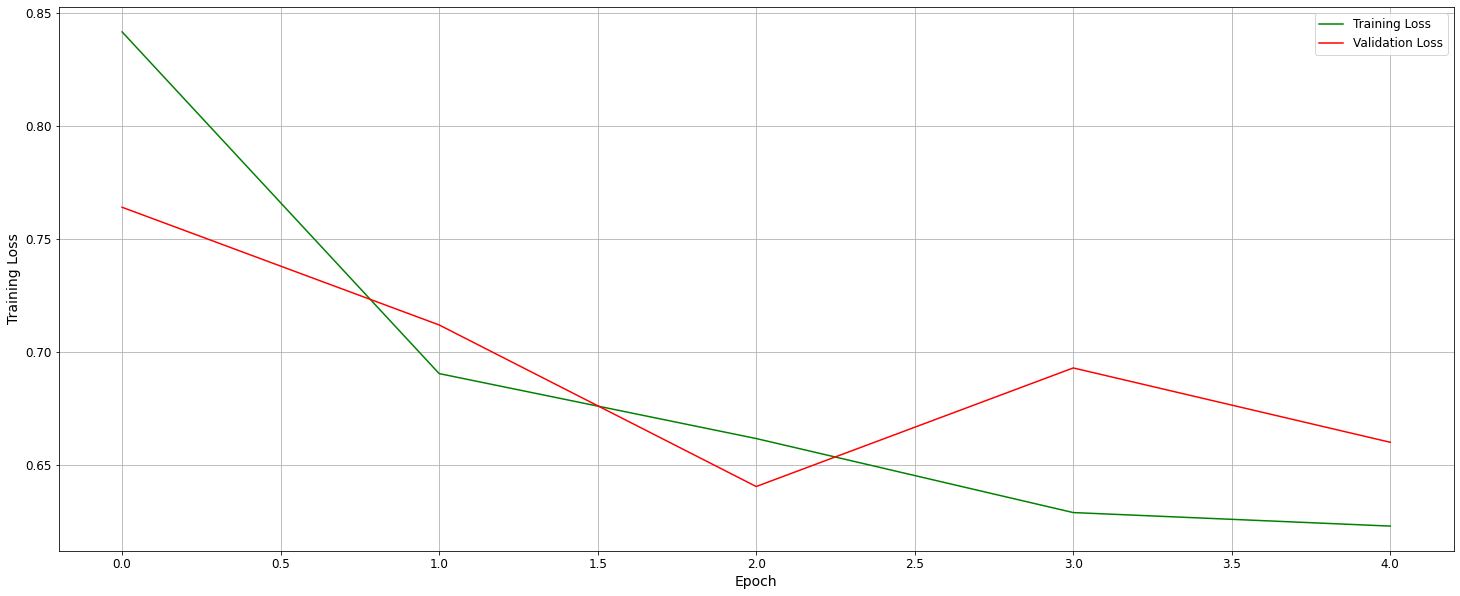

In [130]:
plot_epoch_loss(losses_train[(0.01, 5, 8, 0.1)])

### Singlet Task with Attention

In [ ]:
(0.01, 3, 16, 0.1)

In [342]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                                 c1s=[77],
                                                                                 c2=26,
                                                                                 doc_2_cluster_map=d2c_map,
                                                                                   c2_train_perc=0.1,
                                                                                   learning_rates=[0.01],
                                                                                   epochs=[3],
                                                                                   batch_sizes=[16],
                                                                                   dropouts=[0.1],
                                                                                   with_attention=True,
                                                                                   cuda_device=torch.device('cuda:1'), 
                                                                                   return_model=True,
                                                                                 avg_type="binary",
                                                                                 glove=False,
                                                                                 extreme=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Selected data sizes : 
Train Size : 1136.8500000000001
Test Size : 349.8
Val Size : 262.34999999999997
Percentage of train size for c in c1mix : 1023.1650000000002
Percentage of Val size for c in c1mix : 236.11499999999998
Percentage of test size for c in c1mix : 174.9

Sampled Data Sizes: 
Train Size : (1136, 14)
1 : 569
0 : 567
Test Size : (348, 14)
1 : 174
0 : 174
Val Size : (262, 14)
1 : 131
0 : 131
Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.01
 epoch : 3
 batch_size : 16
 dropout : 0.1

[ Using Seed :  42  ]


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Y1 Pred Dist : 
1 : 889
0 : 247
Predicted Label Shape : (1136,)
True Label Shape : (1136,)
Predicted Label Shape : (1023,)
True Label Shape : (1023,)
Predicted Label Shape : (113,)
True Label Shape : (113,)

Finished running 'evaluate_st' in 0.0184 mins

Y1 Pred Dist : 
1 : 206
0 : 56
Predicted Label Shape : (262,)
True Label Shape : (262,)
Predicted Label Shape : (236,)
True Label Shape : (236,)
Predicted Label Shape : (26,)
True Label Shape : (26,)

Finished running 'evaluate_st' in 0.0073 mins

Y1 Pred Dist : 
1 : 293
0 : 55
Predicted Label Shape : (348,)
True Label Shape : (348,)
Predicted Label Shape : (174,)
True Label Shape : (174,)
Predicted Label Shape : (174,)
True Label Shape : (174,)

Finished running 'evaluate_st' in 0.0084 mins


Finished running 'run_ssda_ST' in 0.1121 mins



In [343]:
attm_s_model = model_dict[(0.01, 3, 16, 0.1)]

In [221]:
select_top_settings(metrics_val,metric_type="F1")

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
42,"(0.01, 3, 16, 0.1)",overall,class_scores,0.767677,0.690909,0.863636,0.738636,0.738636
43,"(0.01, 3, 16, 0.1)",cluster1,class_scores,0.800000,0.720000,0.900000,0.775000,0.775000
44,"(0.01, 3, 16, 0.1)",cluster2,class_scores,0.444444,0.400000,0.500000,0.375000,0.375000


In [222]:
select_top_settings(metrics_val,metric_type="Accuracy")

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
42,"(0.01, 3, 16, 0.1)",overall,class_scores,0.767677,0.690909,0.863636,0.738636,0.738636
43,"(0.01, 3, 16, 0.1)",cluster1,class_scores,0.800000,0.720000,0.900000,0.775000,0.775000
44,"(0.01, 3, 16, 0.1)",cluster2,class_scores,0.444444,0.400000,0.500000,0.375000,0.375000


In [223]:
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.01, 3, 16, 0.1)]

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
42,"(0.01, 3, 16, 0.1)",overall,class_scores,0.610169,0.600000,0.620690,0.610169,0.610345
43,"(0.01, 3, 16, 0.1)",cluster1,class_scores,0.709677,0.666667,0.758621,0.694915,0.695977
44,"(0.01, 3, 16, 0.1)",cluster2,class_scores,0.500000,0.518519,0.482759,0.525424,0.524713


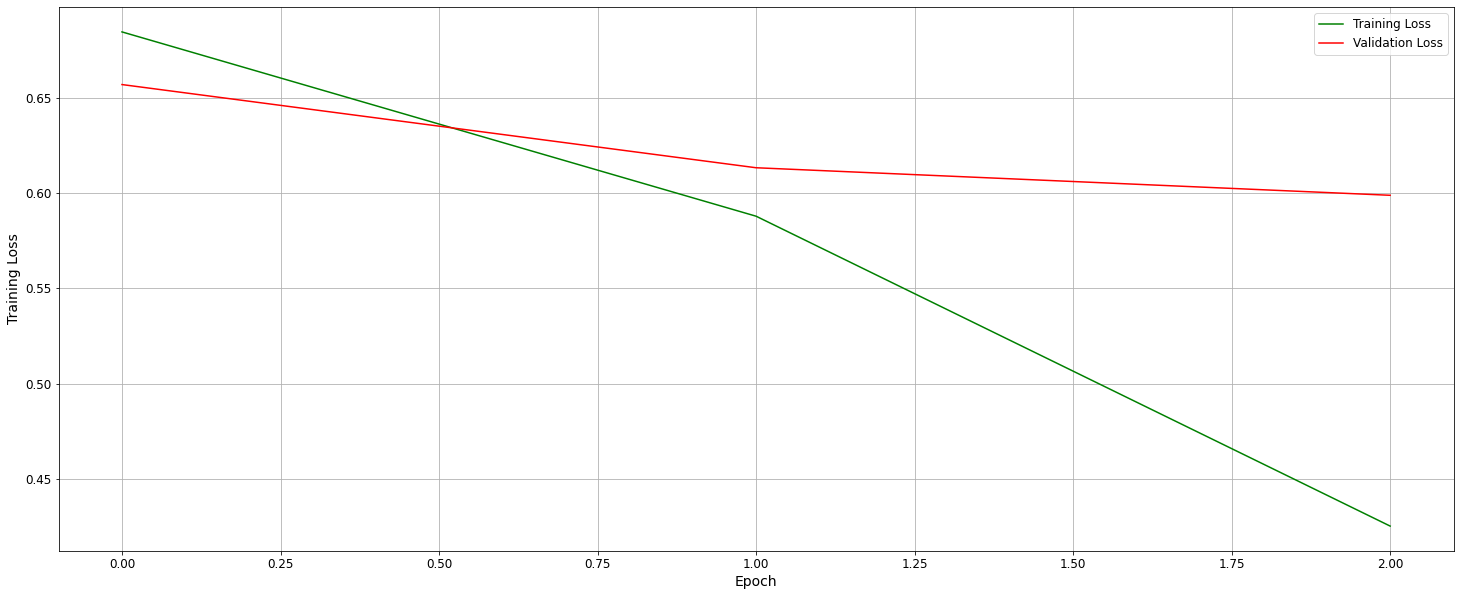

In [193]:
plot_epoch_loss(losses_train[(0.001, 3, 8, 0.1)])

### Multitask With Attention

In [ ]:
(0.001, 8, 16, 0.3, 0.3, 0.05)

In [359]:
metrics_train,metrics_test,metrics_val, losses_train,model_dict = run_ssda_cp_mt(df=rel_df,
                                                                                 c1s=[77],
                                                                                 c2=26,
                                                                                 doc_2_cluster_map=d2c_map,
                                                                                   c2_train_perc=0.1,
                                                                                   learning_rates=[0.001],
                                                                                   epochs=[8],
                                                                                   batch_sizes=[16],
                                                                                   dropouts=[0.3],
                                                                                    word_pred_loss_weights=[0.3],
                                                                                   l2s=[0.05],
                                                                                   cuda_device=torch.device('cuda:1'), 
                                                                                   return_model=True,
                                                                                 avg_type="binary",
                                                                                 glove=False,
                                                                                 extreme=False,loss2=False,bad_term_embeds=bad_term_embeds)

Selected data sizes : 
Train Size : 1136.8500000000001
Test Size : 349.8
Val Size : 262.34999999999997
Percentage of train size for c in c1mix : 1023.1650000000002
Percentage of Val size for c in c1mix : 236.11499999999998
Percentage of test size for c in c1mix : 174.9

Sampled Data Sizes: 
Train Size : (1136, 14)
1 : 569
0 : 567
Test Size : (348, 14)
1 : 174
0 : 174
Val Size : (262, 14)
1 : 131
0 : 131


  0%|          | 0/8 [00:00<?, ?it/s]

Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3

[ Using Seed :  42  ]


100%|██████████| 8/8 [00:14<00:00,  1.75s/it]


Y1 Pred Dist : 
1 : 514
0 : 622
Y2 Pred Dist : 
1 : 0
0 : 1136
Predicted Label Shape : (1136,)
True Label Shape : (1136,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (1023,)
True Label Shape : (1023,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (113,)
True Label Shape : (113,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0185 mins

Y1 Pred Dist : 
1 : 120
0 : 142
Y2 Pred Dist : 
1 : 0
0 : 262
Predicted Label Shape : (262,)
True Label Shape : (262,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (236,)
True Label Shape : (236,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (26,)
True Label Shape : (26,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0066 mins

Y1 Pred Dist : 
1 : 135
0 : 213
Y2 Pred Dist : 
1 : 0
0 : 348
Predicted Label Shape : (348,)
True Label Shape : (348,)
One class predictions for wo

In [360]:
attm_m_model = model_dict[(0.001, 8, 16, 0.3, 0.3, 0.05)]

In [326]:
select_top_settings(metrics_val,metric_type="F1")

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
36,"(0.001, 3, 16, 0.1, 0.1, 0.05)",overall,class_scores,0.694118,0.564593,0.900763,0.603053,0.603053
38,"(0.001, 3, 16, 0.1, 0.1, 0.05)",cluster1,class_scores,0.697368,0.569892,0.898305,0.610169,0.610169
40,"(0.001, 3, 16, 0.1, 0.1, 0.05)",cluster2,class_scores,0.666667,0.521739,0.923077,0.538462,0.538462


In [327]:
select_top_settings(metrics_val,metric_type="Accuracy")

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
126,"(0.001, 5, 16, 0.3, 0.1, 0.05)",overall,class_scores,0.656827,0.635714,0.679389,0.645038,0.645038
128,"(0.001, 5, 16, 0.3, 0.1, 0.05)",cluster1,class_scores,0.658333,0.647541,0.669492,0.652542,0.652542
130,"(0.001, 5, 16, 0.3, 0.1, 0.05)",cluster2,class_scores,0.645161,0.555556,0.769231,0.576923,0.576923


In [330]:
test_res_df = print_res(metrics_test)
test_res_df.loc[test_res_df.Settings == (0.001, 5, 16, 0.3, 0.1, 0.05)]

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
126,"(0.001, 5, 16, 0.3, 0.1, 0.05)",overall,class_scores,0.565217,0.536082,0.597701,0.540230,0.540230
128,"(0.001, 5, 16, 0.3, 0.1, 0.05)",cluster1,class_scores,0.678161,0.678161,0.678161,0.678161,0.678161
130,"(0.001, 5, 16, 0.3, 0.1, 0.05)",cluster2,class_scores,0.463918,0.420561,0.517241,0.402299,0.402299


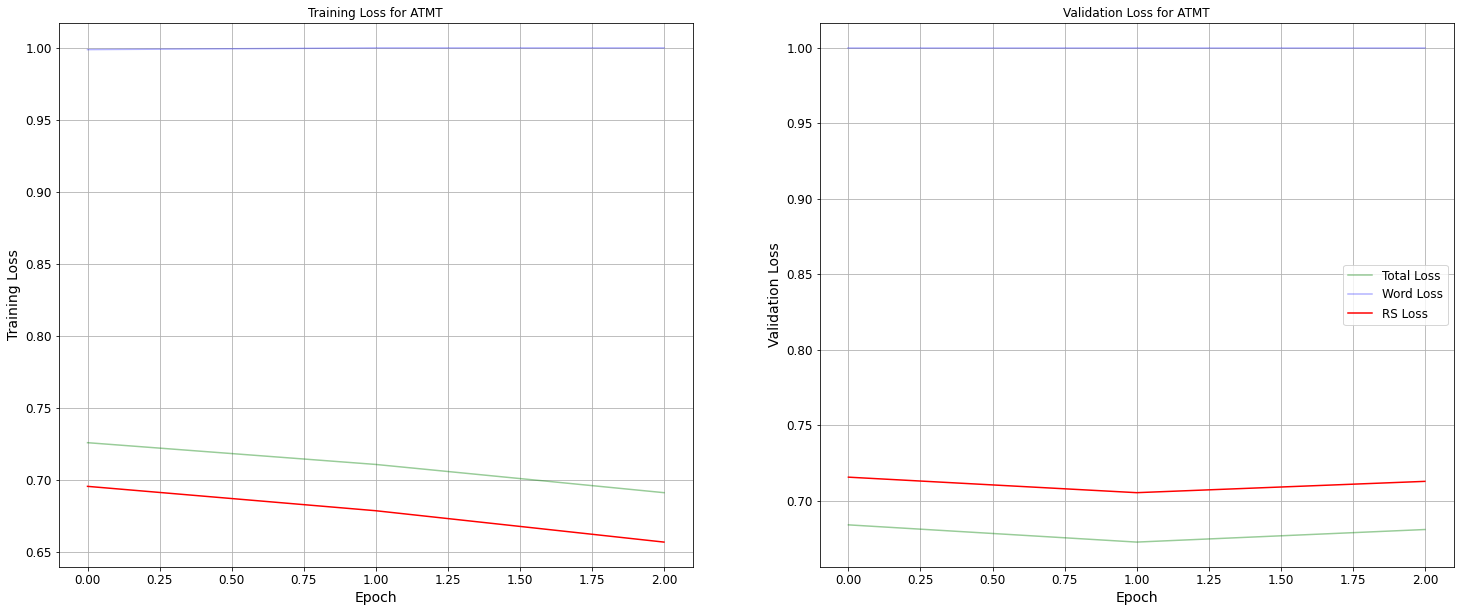

In [331]:
plot_epoch_loss_multi(losses_train[(0.001, 3, 16, 0.1, 0.1, 0.05)])

### Attention Weights

In [333]:
train_n,test_n,val = split_data_mixed(c1s=[77],c2=26,cluster_2_doc_map=d2c_map,df=rel_df,c2_train_perc=0.10)
train_e,test_e,val = split_data_mixed(c1s=[28],c2=35,cluster_2_doc_map=d2c_map_extreme,df=rel_df_extreme,c2_train_perc=0.10)

Selected data sizes : 
Train Size : 1136.8500000000001
Test Size : 349.8
Val Size : 262.34999999999997
Percentage of train size for c in c1mix : 1023.1650000000002
Percentage of Val size for c in c1mix : 236.11499999999998
Percentage of test size for c in c1mix : 174.9

Sampled Data Sizes: 
Train Size : (1136, 14)
1 : 569
0 : 567
Test Size : (348, 14)
1 : 174
0 : 174
Val Size : (262, 14)
1 : 131
0 : 131
Selected data sizes : 
Train Size : 386.75
Test Size : 119.0
Val Size : 89.25
Percentage of train size for c in c1mix : 348.075
Percentage of Val size for c in c1mix : 80.325
Percentage of test size for c in c1mix : 59.5

Sampled Data Sizes: 
Train Size : (386, 14)
1 : 193
0 : 193
Test Size : (118, 14)
1 : 58
0 : 60
Val Size : (88, 14)
1 : 44
0 : 44


In [361]:
multi_att_w_n = get_attention_weights(attm_m_model,test_n,single=False)

100%|██████████| 348/348 [00:02<00:00, 143.86it/s]


In [345]:
single_att_w_n = get_attention_weights(attm_s_model,test_n,single=True)

100%|██████████| 348/348 [00:02<00:00, 134.31it/s]


In [362]:
multi_att_w_agg = aggregate_attW(multi_att_w_n)
ranks = sorted(list(multi_att_w_agg.items()),key=lambda x:x[1],reverse=True)[:25]
for r in ranks:
    print(r)

('president', 0.09364412201744104)
('white', 0.03676608626787316)
('said', 0.031780452950038)
('senate', 0.028107487204614052)
('donald', 0.025296009088992065)
('percent', 0.017589995036149646)
('week', 0.017130842634808435)
('adam', 0.016334127089020812)
('tuesday', 0.016075442347719522)
('democrats', 0.015369330900067)
('fox', 0.013554216127495152)
('john', 0.013206429557428526)
('media', 0.012896961092389855)
('poll', 0.012315049594281216)
('public', 0.01152573133595485)
('democratic', 0.00910125867212937)
('month', 0.008852433731221217)
('house', 0.008841062887659266)
('news', 0.008709089352161765)
('electoral', 0.008474777249740134)
('clinton', 0.008316713360483329)
('presidential', 0.008201811688193726)
('joe', 0.008065498046768772)
('year', 0.008007112313592427)
('far', 0.007835272584968857)


In [350]:
single_att_w_agg = aggregate_attW(single_att_w_n)
ranks = sorted(list(single_att_w_agg.items()),key=lambda x:x[1],reverse=True)[:25]
for r in ranks:
    print(r)

('polls', 0.11025277036074299)
('media', 0.0862050393527039)
('news', 0.05059659658453443)
('said', 0.045915529252475246)
('cnn', 0.031384280441997134)
('reporters', 0.029520724000294145)
('press', 0.026753937796389574)
('opinion', 0.02528168232985196)
('public', 0.024616548318197675)
('released', 0.024447420234761926)
('senate', 0.023913818453271046)
('chamber', 0.02222890521878006)
('polling', 0.018531603508373275)
('conference', 0.017139360600351997)
('told', 0.01522234873664252)
('live', 0.013345269828313959)
('post', 0.013340402666525098)
('real', 0.011456033049306978)
('evidence', 0.011278734370454662)
('articles', 0.010040584291881342)
('wednesday', 0.009662084122023329)
('pressure', 0.009018791363826254)
('short', 0.008940418944669471)
('new', 0.00882725781899361)
('big', 0.00810320845788368)


In [363]:
rank_changes = calc_change_in_rank(single_att_w_n,multi_att_w_n)
rank_changes_list = list(rank_changes.items())

In [364]:
sorted(rank_changes_list,key=lambda x: x[1], reverse=True)[:20]

[('donald', 492),
 ('presidential', 464),
 ('obama', 459),
 ('john', 457),
 ('electoral', 456),
 ('attorney', 425),
 ('mike', 390),
 ('governor', 388),
 ('mitch', 377),
 ('joe', 371),
 ('voter', 369),
 ('vice', 366),
 ('candidate', 365),
 ('chuck', 364),
 ('nancy', 362),
 ('year', 359),
 ('clinton', 348),
 ('registered', 347),
 ('united', 343),
 ('election', 343)]

In [365]:
sorted(rank_changes_list,key=lambda x: x[1], reverse=False)[:20]

[('doing', -429),
 ('upper', -423),
 ('politics', -401),
 ('short', -400),
 ('lines', -399),
 ('line', -377),
 ('course', -372),
 ('coming', -358),
 ('proceedings', -351),
 ('deal', -347),
 ('matter', -345),
 ('power', -339),
 ('chamber', -325),
 ('fight', -322),
 ('colleagues', -322),
 ('constitution', -308),
 ('meeting', -302),
 ('conference', -299),
 ('center', -296),
 ('sure', -296)]

### Extreme Dataset

### Single Task without Attention

### Singlet Task with Attention

### Multitask With Attention

## Experiment 2 - Bert 3 cluster

### Normal Dataset

### Single Task without Attention

### Singlet Task with Attention

### Multitask With Attention

### Extreme Dataset

### Single Task without Attention

### Singlet Task with Attention

### Multitask With Attention

## Experiment 3 - Bert 4 cluster

### Normal Dataset

### Single Task without Attention

### Singlet Task with Attention

### Multitask With Attention

### Extreme Dataset

### Single Task without Attention

### Singlet Task with Attention

### Multitask With Attention

## Experiment 4 - Glove 2 cluster

### Normal Dataset

### Single Task without Attention

### Singlet Task with Attention

### Multitask With Attention

### Extreme Dataset

### Single Task without Attention

### Singlet Task with Attention

### Multitask With Attention

## Experiment 5 - Glove 3 cluster

### Normal Dataset

### Single Task without Attention

### Singlet Task with Attention

### Multitask With Attention

### Extreme Dataset

### Single Task without Attention

### Singlet Task with Attention

### Multitask With Attention

## Experiment 6 - Glove 4 cluster

### Normal Dataset

### Single Task without Attention

### Singlet Task with Attention

### Multitask With Attention

### Extreme Dataset

### Single Task without Attention

### Singlet Task with Attention

### Multitask With Attention